### Contents
1. [Problem Statement](#problem-statement)
2. [Data Wrangling](#data-wrangling)
3. [Plots: A Few Smoothed Examples](#plots-a-few-smoothed-examples)
4. [All Series Plot](#all-series-plot)
5. [Yearly Zonal Plots](#yearly-zonal-plots)
6. [Closer Look](#closer-look)
7. [Seasonalities](#seasonalities)
    * 7.1 [Periodogram View](#periodograms)
    * 7.2 [ACF View](#acf-view)
8. [Feature Variance](#feature-variance)
9. [Complete Preprocessing](#complete-preprocessing)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')

In [4]:
data_path = '../working/all_energy.csv'

In [5]:
df = pd.read_csv(data_path)

In [7]:
df

Дата          ЦЗ         ЗСП  Час  План ГЭС, МВт*ч  \
0       2018-01-01 00:00:00.000  Европа      FZUROE07      8          145.600   
1       2018-01-01 00:00:00.000  Европа      FZURTU08      8            0.000   
2       2018-01-01 00:00:00.000  Европа      FZVLBS15      8          120.000   
3       2018-01-01 00:00:00.000  Европа      FZVLOE13      8          500.000   
4       2018-01-01 00:00:00.000  Европа      FZYUAS18      8            0.000   
...                         ...         ...         ...  ...              ...   
348115  2020-08-24 00:00:00.000  Европа      FZYUKU20     23            6.200   
348116  2020-08-24 00:00:00.000  Европа      FZYUOE16     23          322.788   
348117  2020-08-24 00:00:00.000  Европа      FZYUVG17     23         1120.000   
348118  2020-08-24 00:00:00.000  Европа      FZZMSK26     23            0.000   
348119  2020-08-24 00:00:00.000  Европа      FZZNOE24     23          353.150   

        План АЭС, МВт*ч  План ТЭС, МВт*ч  ТЭС мин, МВт*ч  ТЭС макс, МВт*ч  \
0                 616.0        15310.118       12985.703        18417.555   
1                   0.0        11906.500        8014.692        12166.200   
2                4073.0          576.000         576.000          640.000   
3                  49.5         3857.360        3777.730         4461.390   
4                   0.0          431.500         326.297          531.500   
...                 ...              ...             ...              ...   
348115           4127.0         3009.946        2776.946         4084.745   
348116              0.0          654.597         554.694         1171.700   
348117              0.0          297.000         297.000          393.000   
348118              0.0         4777.119        4137.211         6551.619   
348119          11595.0         6153.317        5569.495         9081.629   

        Потребление, МВт*ч  Экспорт, МВт*ч  Импорт, МВт*ч  План СЭС, МВт*ч  \
0                16133.167        1724.097       2122.273              8.3   
1                 9971.934        1658.871         29.774              0.0   
2                 1375.474        3260.660          1.122              0.6   
3                 5812.795        1369.469       2873.540              0.0   
4                  532.284          30.329        154.762              2.0   
...                    ...             ...            ...              ...   
348115            5558.013        1812.187        364.917              0.0   
348116            1652.503         214.470        949.979              0.0   
348117            1411.464         848.521        899.929              0.0   
348118            9348.429          97.190       4778.966              0.0   
348119           14649.752        6230.060       3381.602              0.0   

        План ВЭС, МВт*ч  План ВИЭ, МВт*ч  Ценопринимающее предложение, МВт*ч  \
0                   0.0                0                            82858.55   
1                   0.0                0                            82858.55   
2                   0.0                0                            82858.55   
3                   3.5                0                            82858.55   
4                   0.0                0                            82858.55   
...                 ...              ...                                 ...   
348115            105.3                0                            69677.56   
348116              0.0                0                            69677.56   
348117              0.0                0                            69677.56   
348118              0.0                0                            69677.56   
348119              0.0                0                            69677.56   

        Ценопринимание сверх минимальной мощности, МВт*ч  \
0                                               6103.482   
1                                               6103.482   
2                                               610

### Problem Statement
[[To the top]](#Contents)

The task is to predict energy prices (Цена продажи, руб./МВт*ч, the rightmost column) for the next day (24 hours)

Let's have a look at the data

### Data Wrangling
[[To the top]](#Contents)

In [8]:
df.isna().sum(axis=0)

Дата                                                0
ЦЗ                                                  0
ЗСП                                                 0
Час                                                 0
План ГЭС, МВт*ч                                     0
План АЭС, МВт*ч                                     0
План ТЭС, МВт*ч                                     0
ТЭС мин, МВт*ч                                      0
ТЭС макс, МВт*ч                                     0
Потребление, МВт*ч                                  0
Экспорт, МВт*ч                                      0
Импорт, МВт*ч                                       0
План СЭС, МВт*ч                                     0
План ВЭС, МВт*ч                                     0
План ВИЭ, МВт*ч                                     0
Ценопринимающее предложение, МВт*ч                  0
Ценопринимание сверх минимальной мощности, МВт*ч    0
Цена продажи, руб./МВт*ч                            0
dtype: int64

Let's change column names for the sake of easier access/readability

In [9]:
new_names = ['date', 
             'price_zone', 
             'free_transfer_zone', 
             'hour', 
             'hydro_plan',
             'nuclear_plan', 
             'thermal_plan', 
             'thermal_min', 
             'thermal_max',
             'consumption', 
             'export',
             'import',
             'solar_plan',
             'wind_plan',
             'renewable_plan',
             'supply_1',
             'supply_2',
             'price',
            ]

df = df.rename(columns = dict(zip(df.columns, new_names)))
df.columns

Index(['date', 'price_zone', 'free_transfer_zone', 'hour', 'hydro_plan',
       'nuclear_plan', 'thermal_plan', 'thermal_min', 'thermal_max',
       'consumption', 'export', 'import', 'solar_plan', 'wind_plan',
       'renewable_plan', 'supply_1', 'supply_2', 'price'],
      dtype='object')

In [10]:
for col in df.columns:
    print(col)
    print(df[col].value_counts().sort_index())
    print()

date
date
2018-01-01 00:00:00.000    360
2018-01-02 00:00:00.000    360
2018-01-03 00:00:00.000    360
2018-01-04 00:00:00.000    360
2018-01-05 00:00:00.000    360
                          ... 
2020-08-20 00:00:00.000    360
2020-08-21 00:00:00.000    360
2020-08-22 00:00:00.000    360
2020-08-23 00:00:00.000    360
2020-08-24 00:00:00.000    360
Name: count, Length: 967, dtype: int64

price_zone
price_zone
Европа        348120
Name: count, dtype: int64

free_transfer_zone
free_transfer_zone
FZSZKO28      23208
FZSZOE27      23208
FZURKR12      23208
FZURNT09      23208
FZUROE07      23208
FZURTU08      23208
FZVLBS15      23208
FZVLOE13      23208
FZYUAS18      23208
FZYUDA23      23208
FZYUKU20      23208
FZYUOE16      23208
FZYUVG17      23208
FZZMSK26      23208
FZZNOE24      23208
Name: count, dtype: int64

hour
hour
0     14505
1     14505
2     14505
3     14505
4     14505
5     14505
6     14505
7     14505
8     14505
9     14505
10    14505
11    14505
12    14505
13    14

Value counts suggest that: 

- *date* is datetime
- *price_zone* and *renewable_plan* are zero-variance and thus could be dropped
- *free_transfer_zone* is categorical
- hydro-, nuclear-, solar- and wind plans have sizeable portions of zeros (see below)

In [11]:
with pd.option_context("display.precision", 2): 
    print( 
        df
        .apply(lambda col: col.value_counts()[0] / df.shape[0] * 100 if any(col==0) else 0)
        .sort_values()
        .rename('fraction of zeros, %')
    )

date                    0.00
price_zone              0.00
free_transfer_zone      0.00
supply_1                0.00
consumption             0.00
supply_2                0.00
price                   0.14
thermal_min             0.43
thermal_plan            0.43
thermal_max             0.43
hour                    4.17
export                  6.53
import                  9.49
hydro_plan             26.78
nuclear_plan           54.34
solar_plan             78.25
wind_plan              86.67
renewable_plan        100.00
Name: fraction of zeros, %, dtype: float64


In [12]:
df.dtypes

date                   object
price_zone             object
free_transfer_zone     object
hour                    int64
hydro_plan            float64
nuclear_plan          float64
thermal_plan          float64
thermal_min           float64
thermal_max           float64
consumption           float64
export                float64
import                float64
solar_plan            float64
wind_plan             float64
renewable_plan          int64
supply_1              float64
supply_2              float64
price                 float64
dtype: object

<br>
Can we downcast default float64 to save memory?

Here's a simple routine to check actual value ranges 

In [13]:
def suggest_compact_dtypes(df: pd.DataFrame, 
                           columns: list[str] = None,
                           ignore_nans: bool = False):
    if not ignore_nans and df.isna().sum().sum()>0:
        raise ValueError("dataframe contains nan values; some columns won't be converted because of nans")
        
    if columns is None:
        columns = df.columns
    int_types = ['int8', 'int16', 'int32', 'int64']
    float_types = ['float16', 'float32', 'float64']
    
    convert = {}
    for c in columns:    
        vals = df.loc[df.loc[:,c].notna(), c] 
        if vals.dtype==object:
            try:
                pd.to_datetime(vals)
                #print(f'{c} is categorical')
                convert[c] = 'datetime64[ns]'
                continue
            except:
                print(f'failed to convert {c} to datetime64[ns]')
            
            try:
                vals.astype('category')
                #print(f'{c} is categorical')
                convert[c] = 'category'
                continue
            except:
                print(f'failed to convert {c} to categorical type')
                
        if (vals.astype('int64') == vals).all():
            types = int_types
            info = np.iinfo
        else:
            types = float_types
            info = np.finfo
        
        for t in types:
            if (vals.min() >= info(t).min) and\
            (vals.max() <= info(t).max):
                convert[c] = t
                break
        if c not in convert:
            raise ValueError(f"no suggestion for column {c}")
        
    return convert

In [14]:
suggest_compact_dtypes(df)

failed to convert price_zone to datetime64[ns]
failed to convert free_transfer_zone to datetime64[ns]


/tmp/ipykernel_69191/3340107802.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(vals)


{'date': 'datetime64[ns]',
 'price_zone': 'category',
 'free_transfer_zone': 'category',
 'hour': 'int8',
 'hydro_plan': 'float16',
 'nuclear_plan': 'float16',
 'thermal_plan': 'float16',
 'thermal_min': 'float16',
 'thermal_max': 'float16',
 'consumption': 'float16',
 'export': 'float16',
 'import': 'float16',
 'solar_plan': 'float16',
 'wind_plan': 'float16',
 'renewable_plan': 'int8',
 'supply_1': 'float32',
 'supply_2': 'float16',
 'price': 'float16'}

<br>
It appears float16 would be enough, but

In [15]:
( df
 .select_dtypes('float64')
 .astype('float16')
 .mean(axis=0)
)

/media/forveg/battleground/venvs2/energy-ts/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:133: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
/media/forveg/battleground/venvs2/energy-ts/lib/python3.10/site-packages/pandas/core/nanops.py:1496: RuntimeWarning: overflow encountered in cast
  return count.astype(dtype, copy=False)
/media/forveg/battleground/venvs2/energy-ts/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


hydro_plan     NaN
nuclear_plan   NaN
thermal_plan   NaN
thermal_min    NaN
thermal_max    NaN
consumption    NaN
export         NaN
import         NaN
solar_plan     NaN
wind_plan      NaN
supply_1       NaN
supply_2       NaN
price          NaN
dtype: float16

We get NaNs during aggregation, which means summation causes overflow.
Checking float32 now

In [16]:
( df
 .select_dtypes('float64')
 .astype('float32')
 .mean(axis=0)
)

hydro_plan        534.579773
nuclear_plan     1560.423706
thermal_plan     3913.612793
thermal_min      3025.442627
thermal_max      4477.095215
consumption      5747.527344
export           1515.226074
import           1427.516602
solar_plan          9.413484
wind_plan           2.601912
supply_1        82868.078125
supply_2         5942.295410
price            1210.504272
dtype: float32

float32 is big enough.  
  
Apply changes, discussed so far:

In [17]:
df = ( df
      # casting\shrinking
      .astype({'date': 'datetime64[ns]',
               'free_transfer_zone': 'category',
               'hour': 'int8'})
      .astype({ col: 'float32' for col in df.select_dtypes('float64').columns })
      
      # dropping zero-variance features
      .drop(columns = ['price_zone',
                       'renewable_plan'])
      
      # removing trailing spaces
      .pipe(lambda df: df.assign(free_transfer_zone =
              df.free_transfer_zone.cat.rename_categories(lambda s: s.strip())))
)

In [18]:
zones = df.free_transfer_zone.unique()
list(zip(range(len(zones)), zones))

[(0, 'FZUROE07'),
 (1, 'FZURTU08'),
 (2, 'FZVLBS15'),
 (3, 'FZVLOE13'),
 (4, 'FZYUAS18'),
 (5, 'FZYUDA23'),
 (6, 'FZYUKU20'),
 (7, 'FZYUOE16'),
 (8, 'FZYUVG17'),
 (9, 'FZZMSK26'),
 (10, 'FZSZKO28'),
 (11, 'FZSZOE27'),
 (12, 'FZURKR12'),
 (13, 'FZZNOE24'),
 (14, 'FZURNT09')]

We have 15 transfer zones

In [19]:
pd.options.display.max_rows = 50
pd.options.display.min_rows = 50

In [20]:
df.date.value_counts().shape[0] * 15

14505

In [34]:
df.groupby(['date', 'free_transfer_zone'], 
           observed=False)['price'].count()
# observed=False tells pandas to show *all* combinations 
# (cartesian product) of categories we group by, 
# including combinations absent from actual data

date        free_transfer_zone
2018-01-01  FZSZKO28              24
            FZSZOE27              24
            FZURKR12              24
            FZURNT09              24
            FZUROE07              24
            FZURTU08              24
            FZVLBS15              24
            FZVLOE13              24
            FZYUAS18              24
            FZYUDA23              24
            FZYUKU20              24
            FZYUOE16              24
            FZYUVG17              24
            FZZMSK26              24
            FZZNOE24              24
2018-01-02  FZSZKO28              24
            FZSZOE27              24
            FZURKR12              24
            FZURNT09              24
            FZUROE07              24
            FZURTU08              24
            FZVLBS15              24
            FZVLOE13              24
            FZYUAS18              24
            FZYUDA23              24
                                  ..
2020-08

In [21]:
all(df.groupby(['date', 'free_transfer_zone'],
              observed=False)['price'].count() == 24)

True

<br>
Each date is associated with 24 records -- for each zone. 24 hours? 

In [22]:
df.hour.value_counts().sort_index()

hour
0     14505
1     14505
2     14505
3     14505
4     14505
5     14505
6     14505
7     14505
8     14505
9     14505
10    14505
11    14505
12    14505
13    14505
14    14505
15    14505
16    14505
17    14505
18    14505
19    14505
20    14505
21    14505
22    14505
23    14505
Name: count, dtype: int64

In [21]:
all(df.groupby(['date', 'free_transfer_zone', 'hour'],
              observed=False)['price'].count() == 1)

True

Right.

In [22]:
all(df['date'].sort_values().reset_index() == df['date'].reset_index())

True

Dates are sorted

In [23]:
(df['date'].iloc[1:].reset_index() - df['date'].iloc[:-1].reset_index())['date'].value_counts()

date
0 days    347153
1 days       966
Name: count, dtype: int64

There are no gaps between consecutive dates (it's either the same day or adjacent days)

Here's the next batch of transforms:

1. Constructing a single datetime column from dates and hours
2. Pivoting table to get datetime index and free_transfer_zone as a new column level:
   each zone corresponds to a bunch of separate time series (price, import, export, etc)

In [24]:
df = ( df
      .assign( dtime=df['date'] + pd.to_timedelta(df.hour, unit='hour'))
      .drop(columns=['date', 'hour'])
      .pivot(index='dtime', columns='free_transfer_zone')
      .sort_index()
     )

Let's chart resulting price series

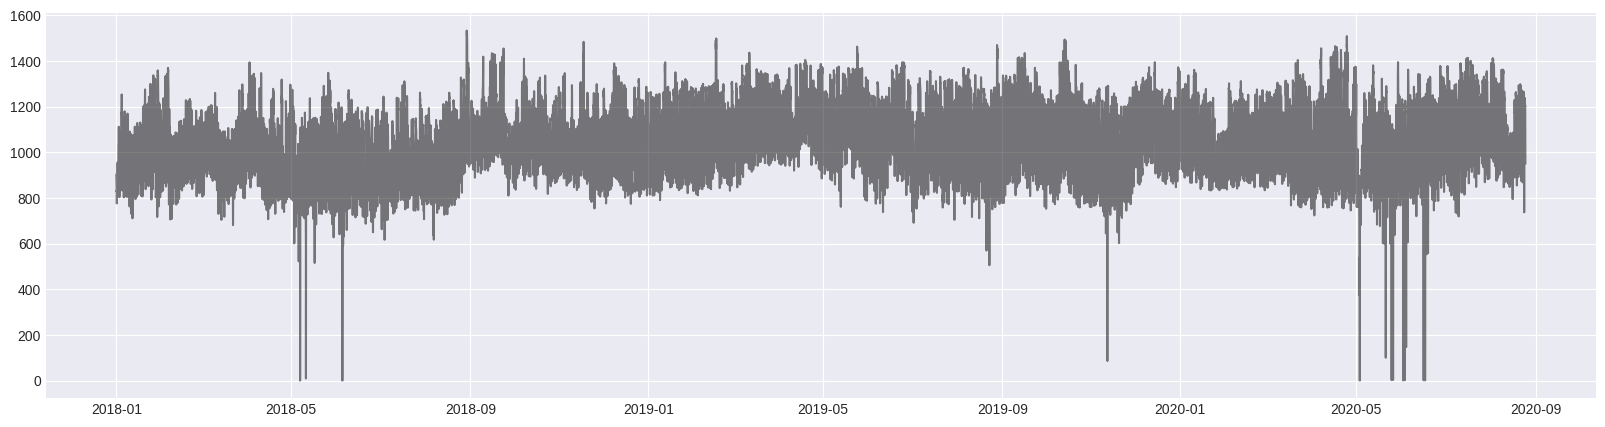

In [25]:
vals = ( df.loc[:,('price', zones[0])])
    
fig,ax=plt.subplots(figsize=(20,5))
ax.plot(vals.index, vals.values, c='k', alpha=0.5);

Too many values to be discernible. Smoothed series should look better

### Plots: A Few Smoothed Examples
[[To the top]](#Contents)

In [26]:
import matplotlib.dates as mdates

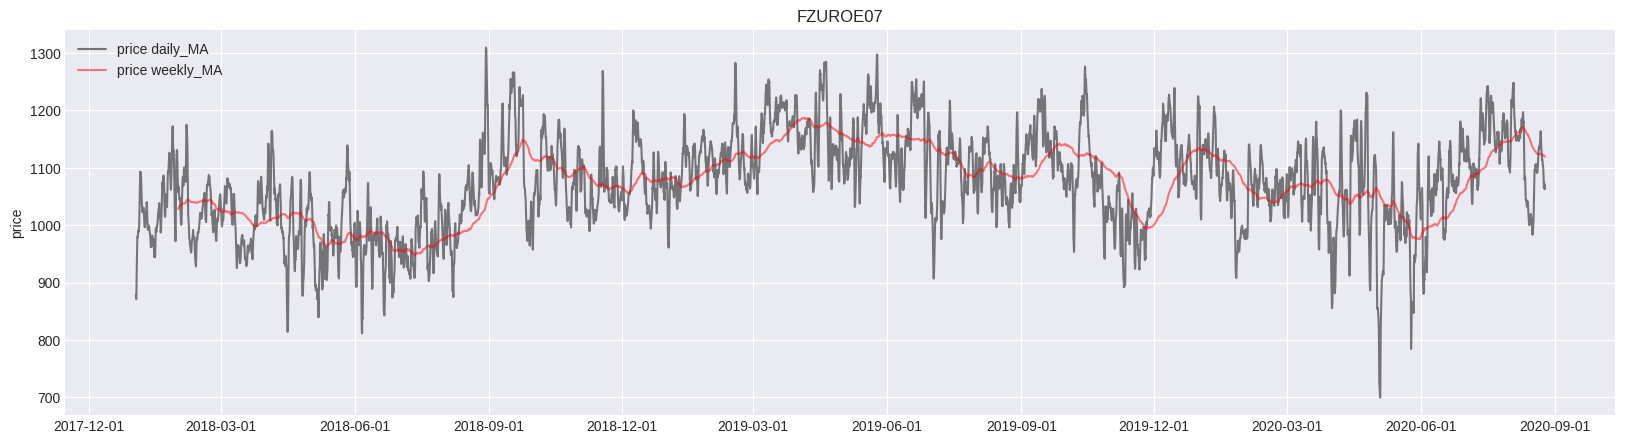

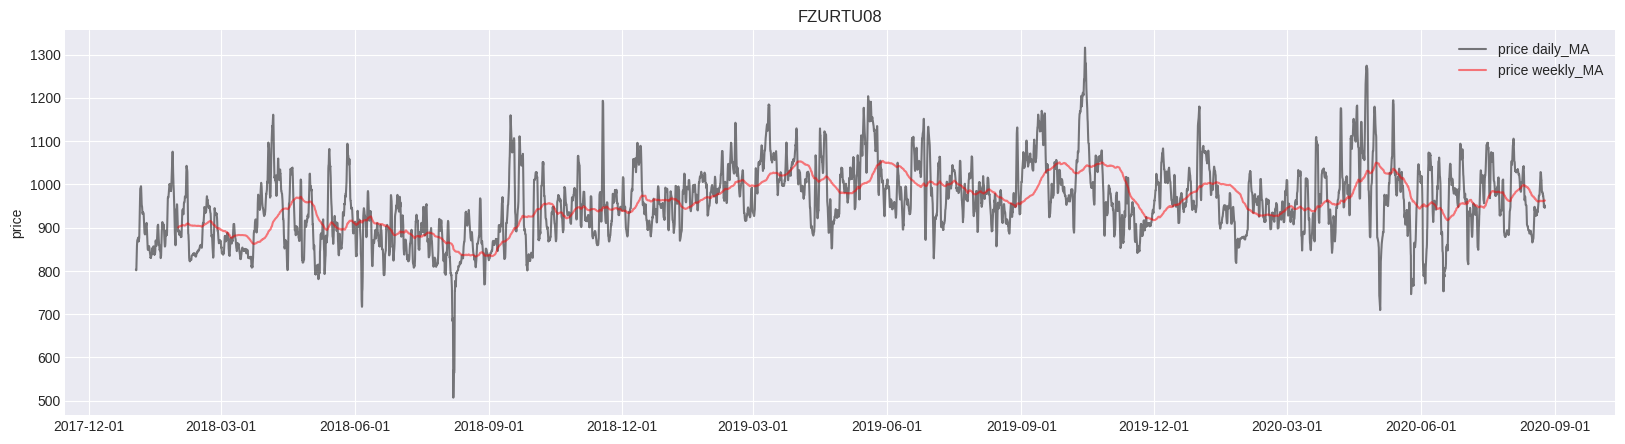

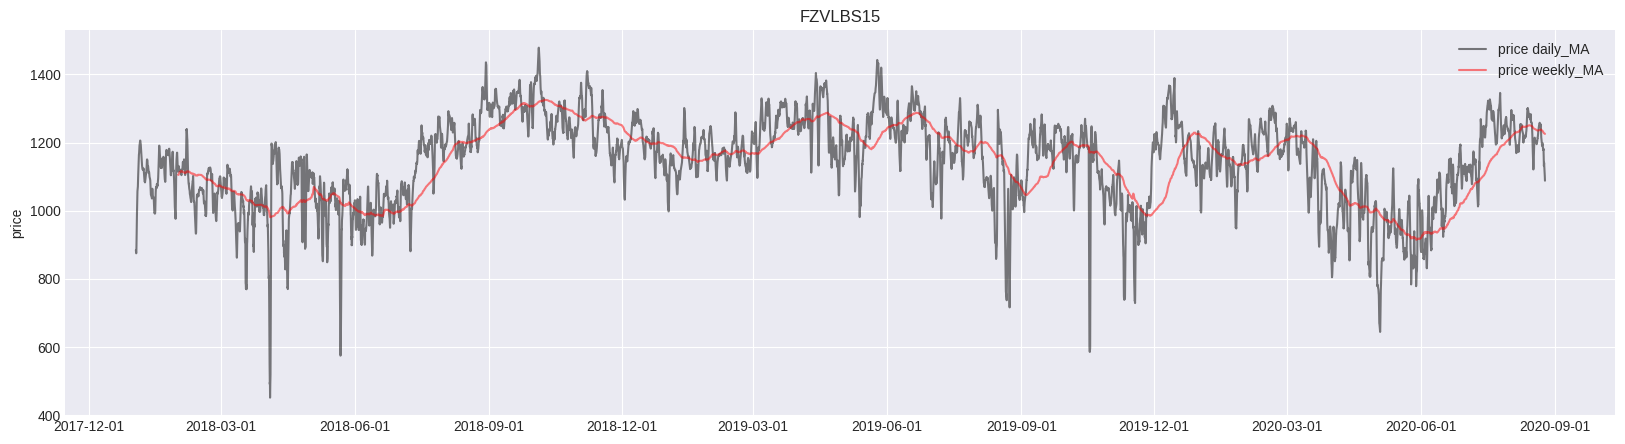

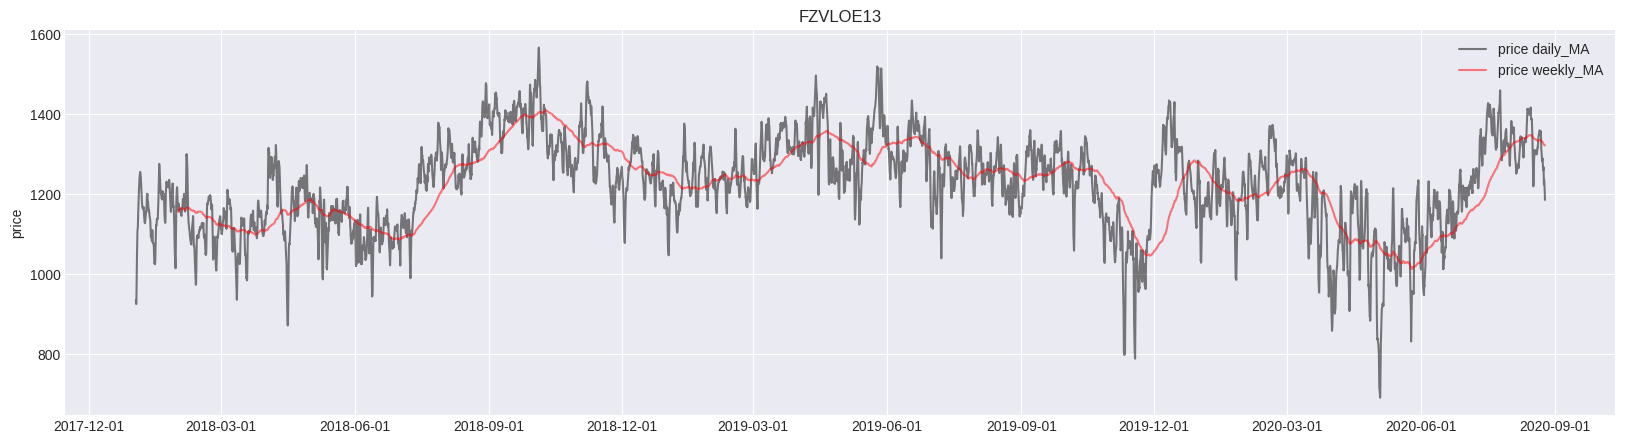

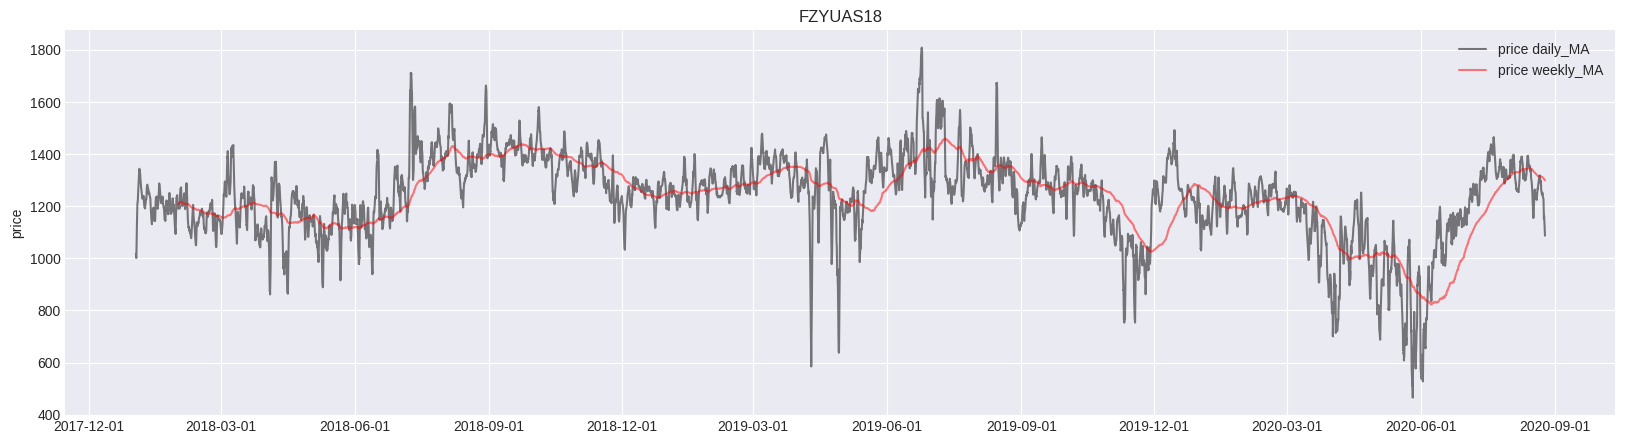

In [27]:
for i in range(5):
    vals = ( df.loc[:,('price',zones[i])]
          .rolling(24)
          .mean())
    
    fig,ax=plt.subplots(figsize=(20,5))
    ax.plot(vals.index, vals.values, c='k', alpha=0.5)
    
    vals72 = ( df.loc[:,('price',zones[i])]
          .rolling(720)
          .mean())
    ax.plot(vals72.index, vals72.values, c='r', alpha=0.5)
    
    ax.set_title(zones[i])
    ax.set_ylabel('price')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[3,6,9,12]))
    ax.legend(labels=['price daily_MA', 'price weekly_MA']);

### All Series Plot
[[To the top]](#Contents)

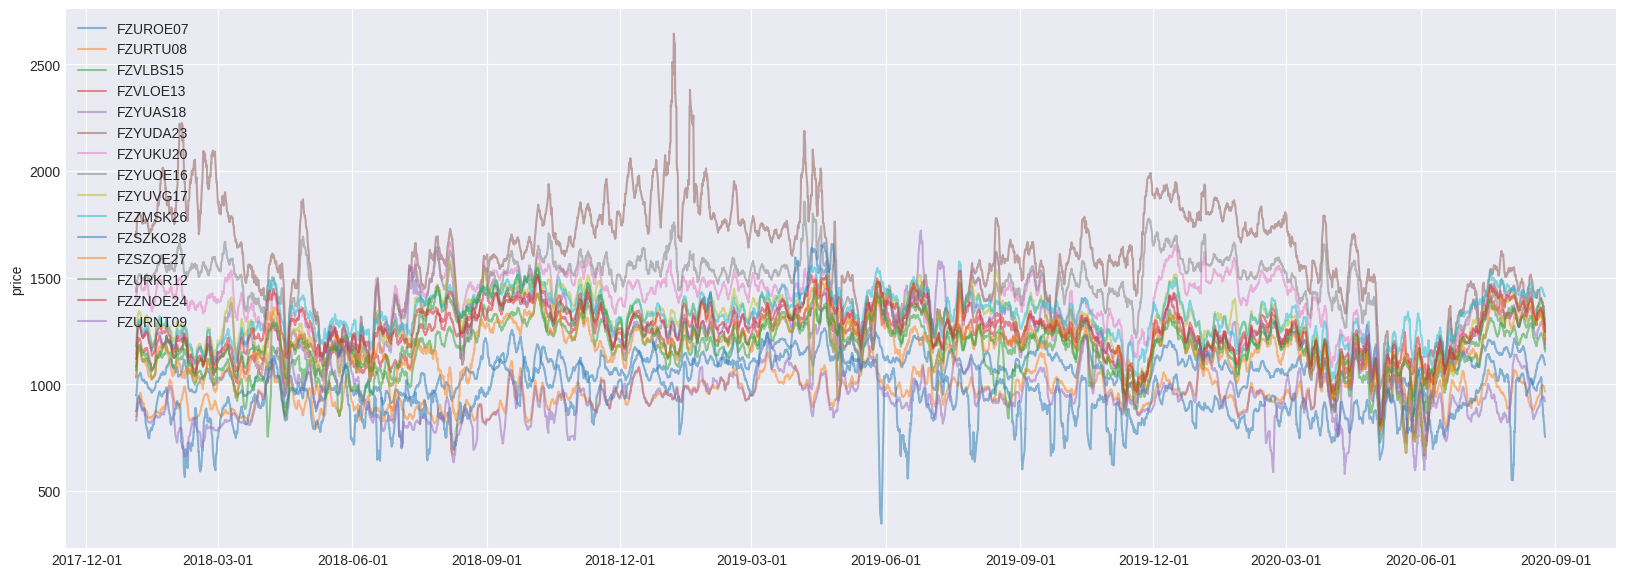

In [29]:
fig,ax=plt.subplots(figsize=(20,7))
for zone in zones:
    vals = ( df.loc[:,('price',zone)]
          .rolling(72)
          .mean())

    ax.plot(vals.index, vals.values, alpha=0.5)
    
ax.set_ylabel('price')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[3,6,9,12]))
ax.legend(labels=zones);

Somewhat correlated, especially at the shock points. Also there are clusters of more closely correlated series.  
Correlated series could be used for agmentation during training, since they are not that correlated to be redundant, and on the other hand, not so dissimilar as to destabilize training process

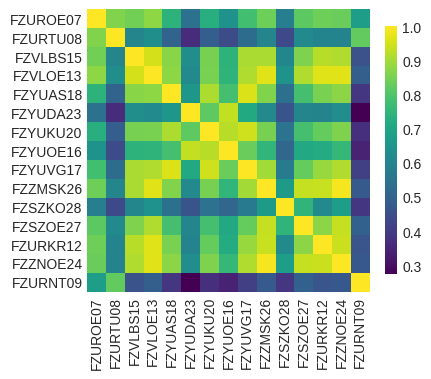

In [100]:
fig,ax=plt.subplots(figsize=(4,4))
img = ax.imshow(df.loc[:, [('price',zone) for zone in zones]].corr(), cmap='viridis')

ax.set_xticks(np.arange(len(zones)))
ax.set_yticks(np.arange(len(zones)))
ax.set_xticklabels(zones, rotation=90)
ax.set_yticklabels(zones)
fig.colorbar(img, ax=ax, fraction=0.04);

### Yearly Zonal Plots
[[To the top]](#Contents)

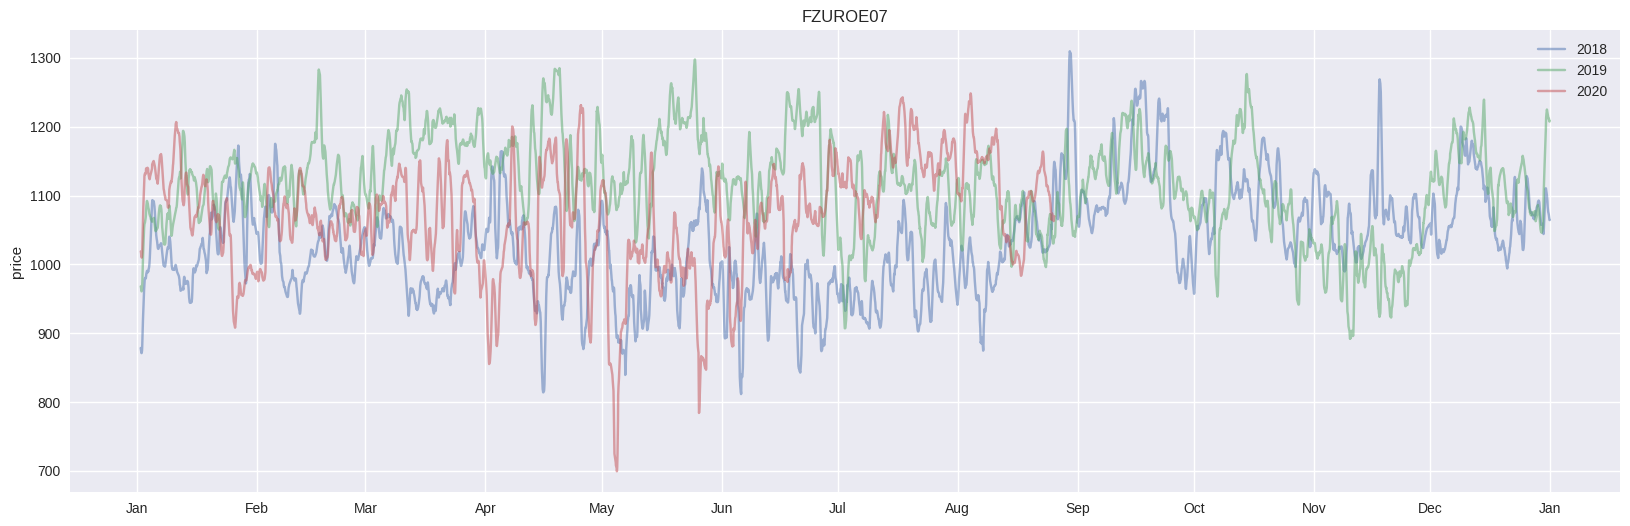

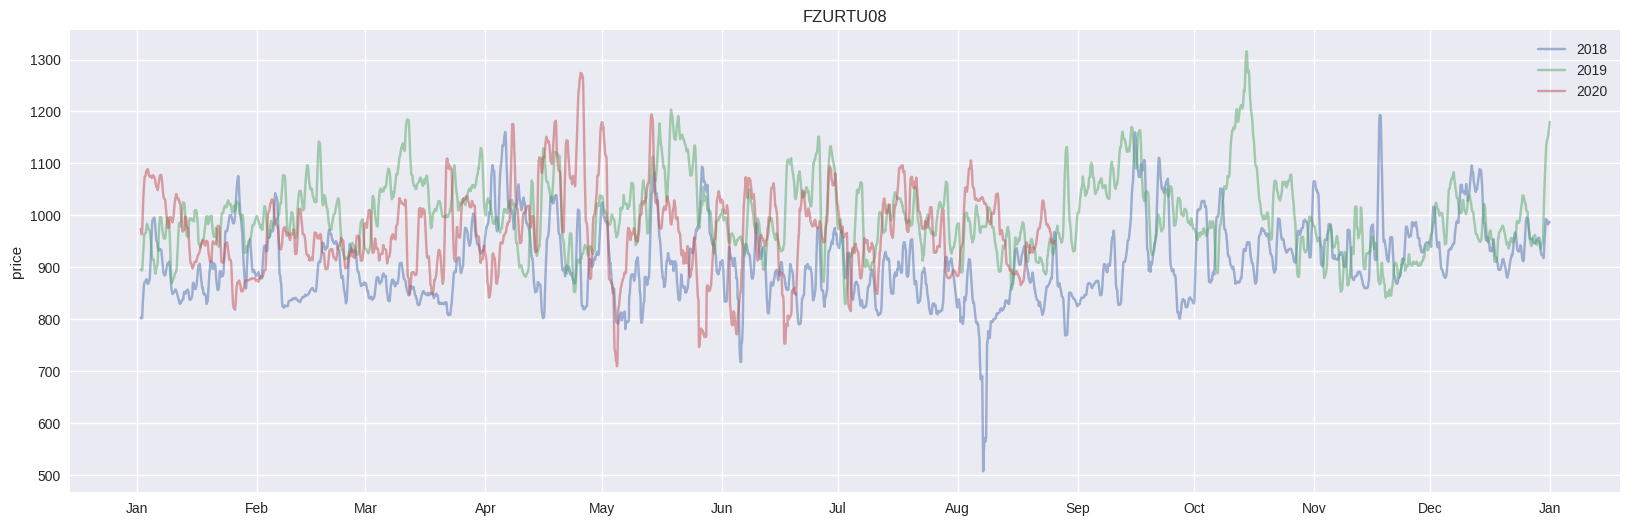

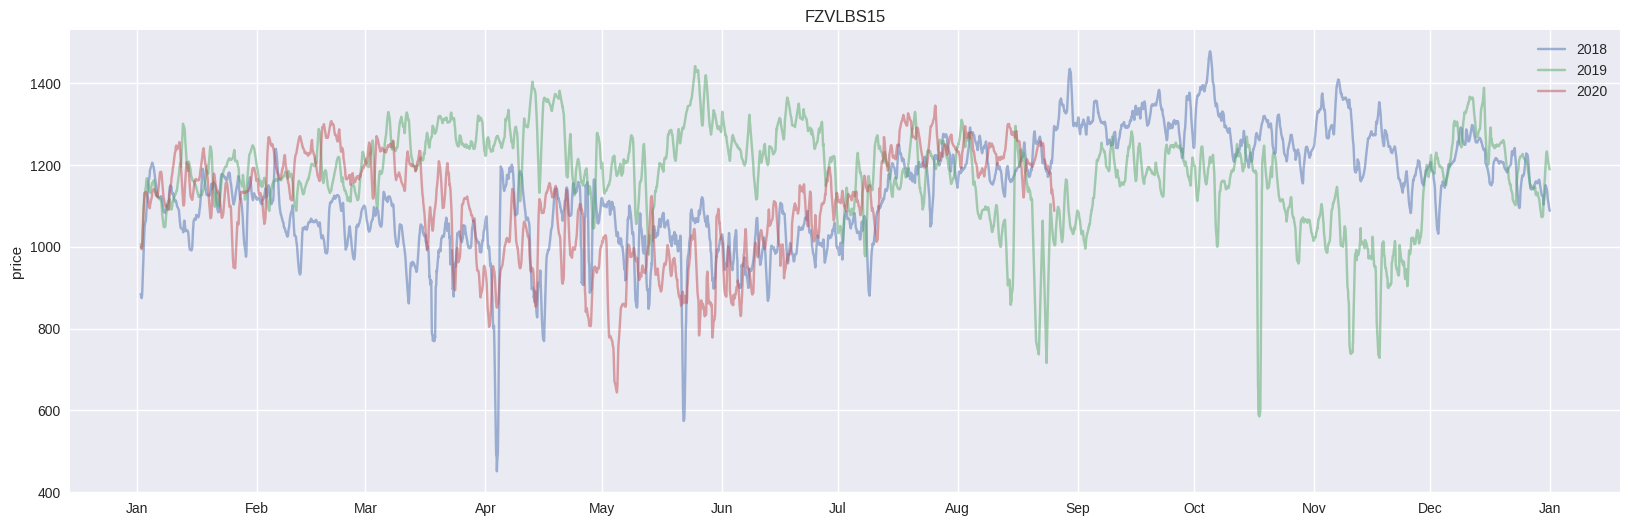

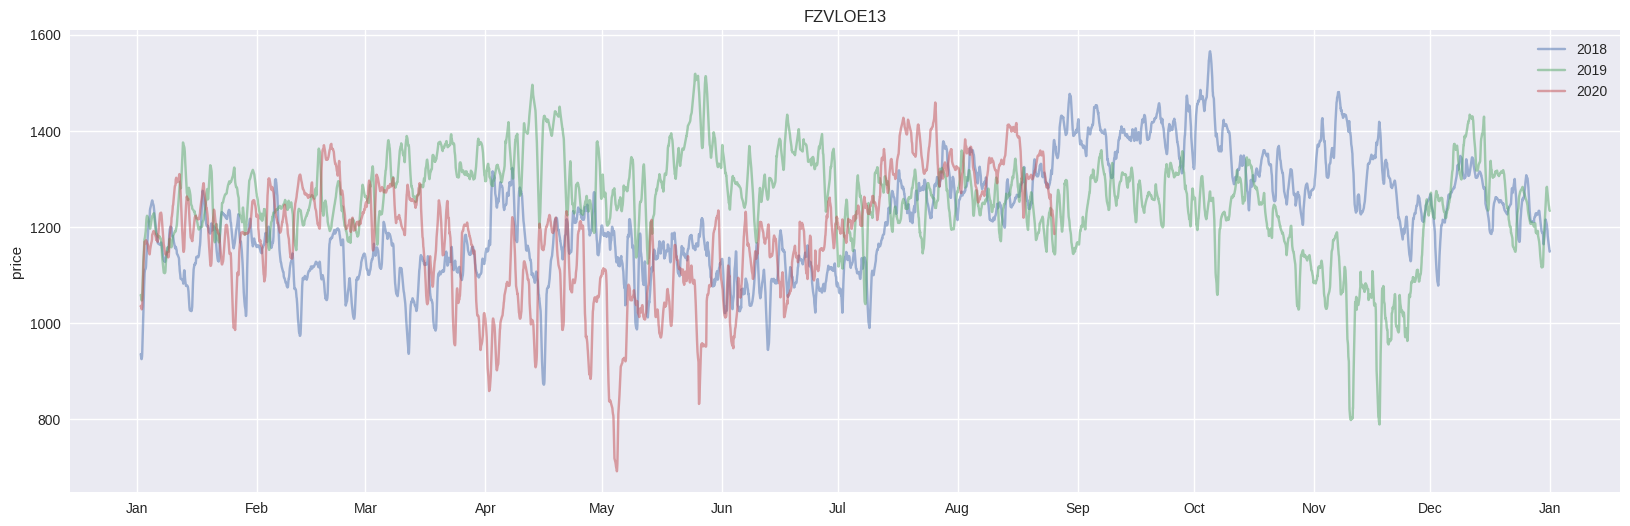

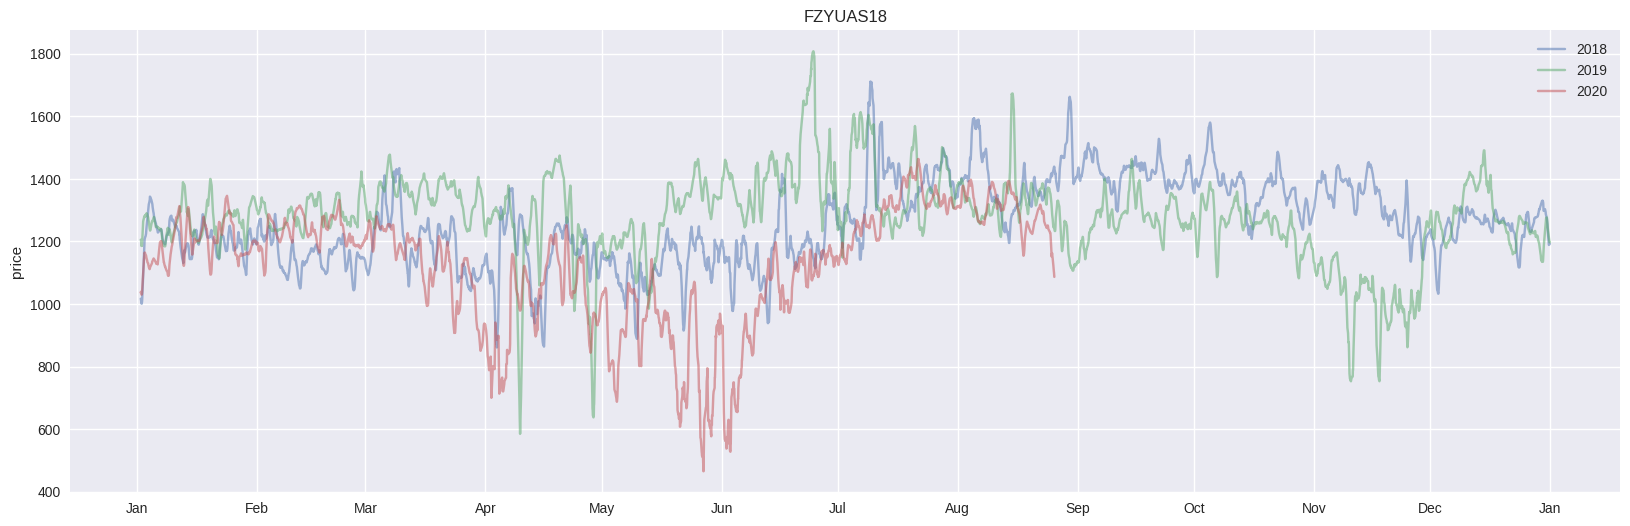

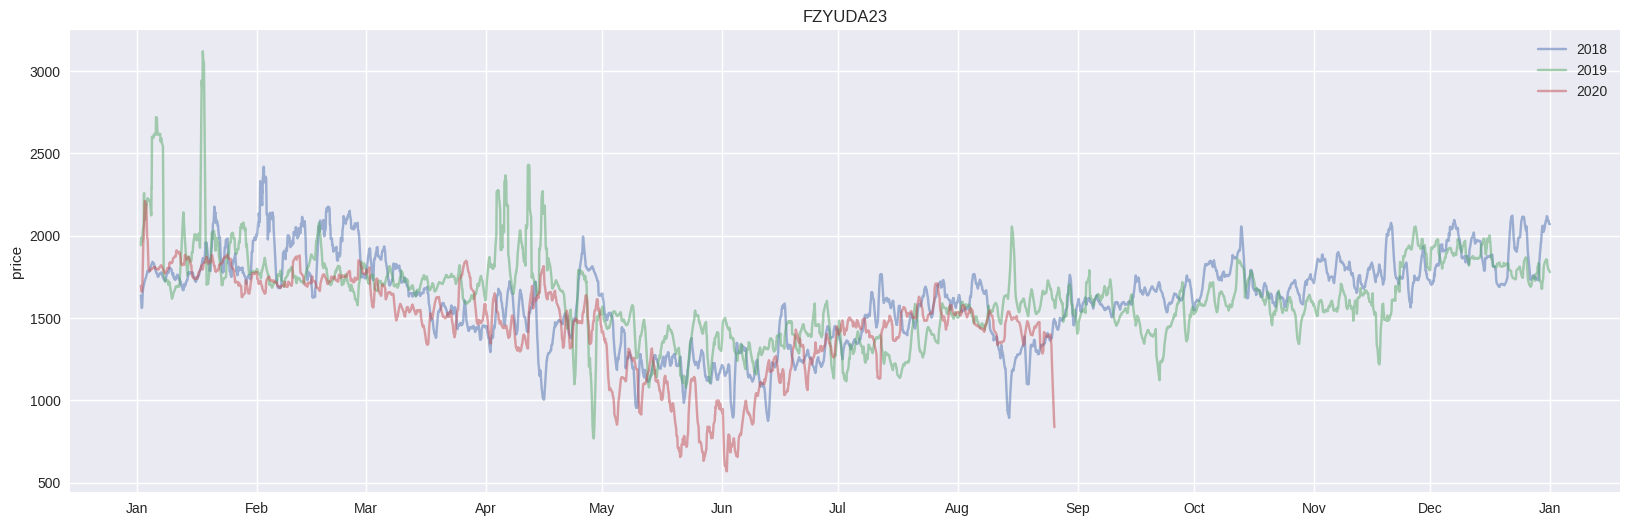

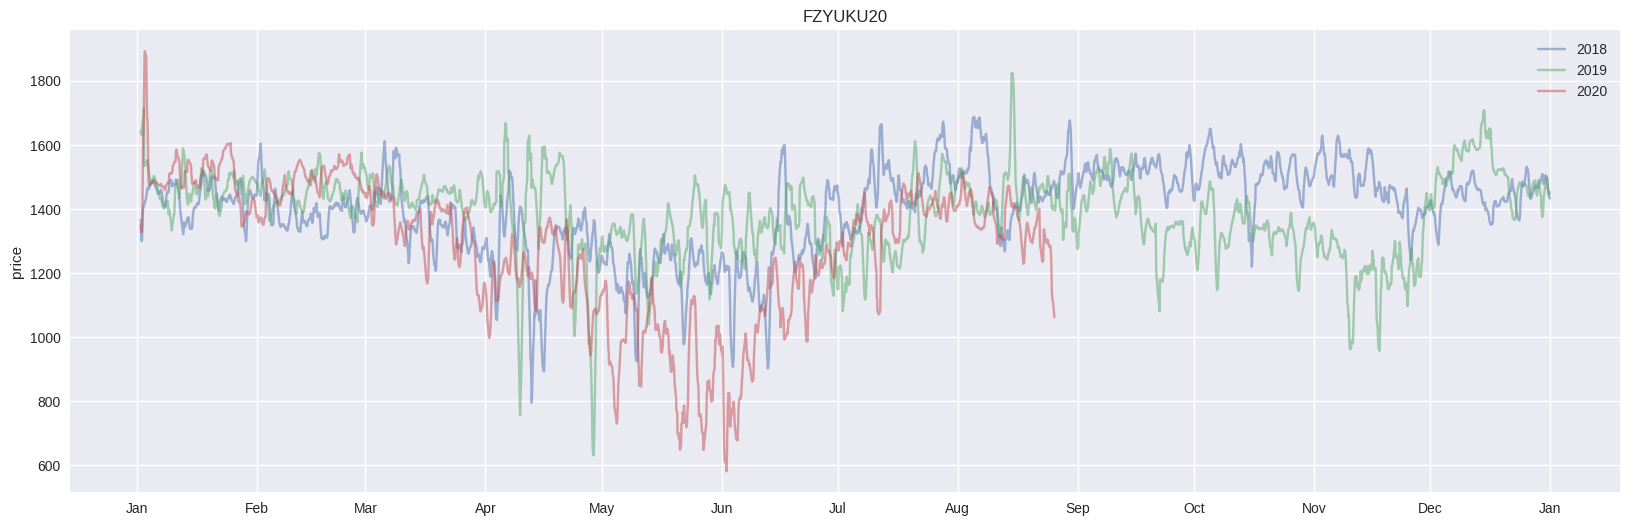

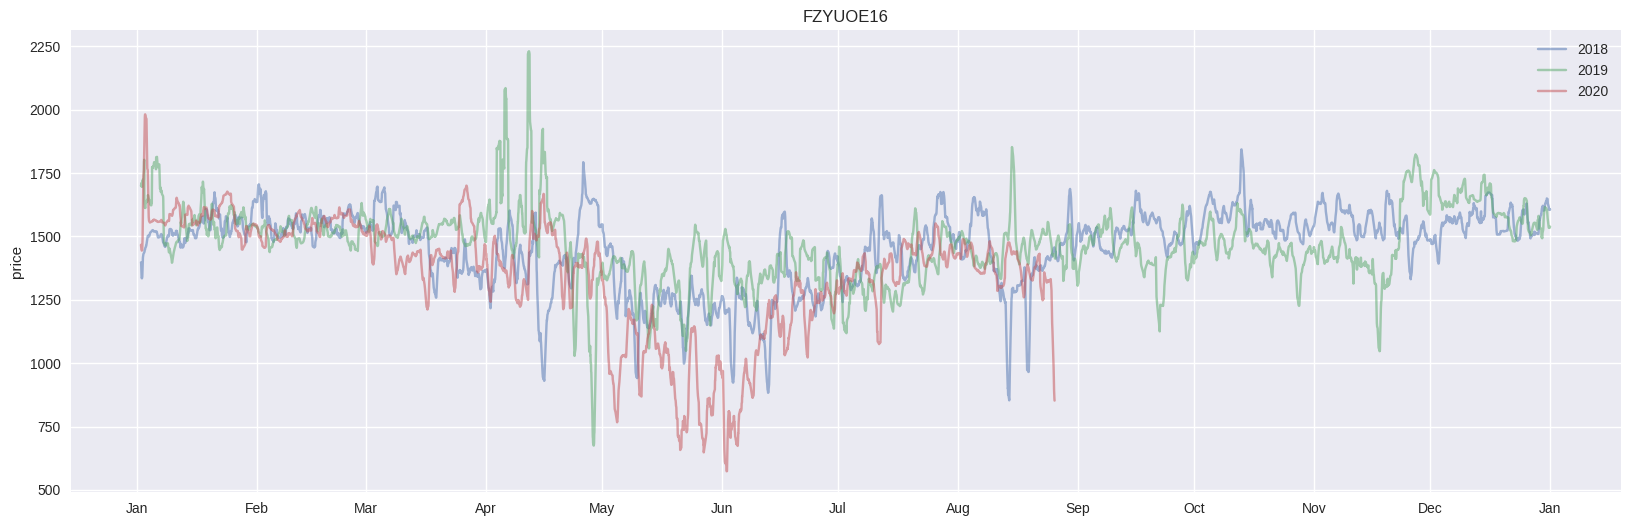

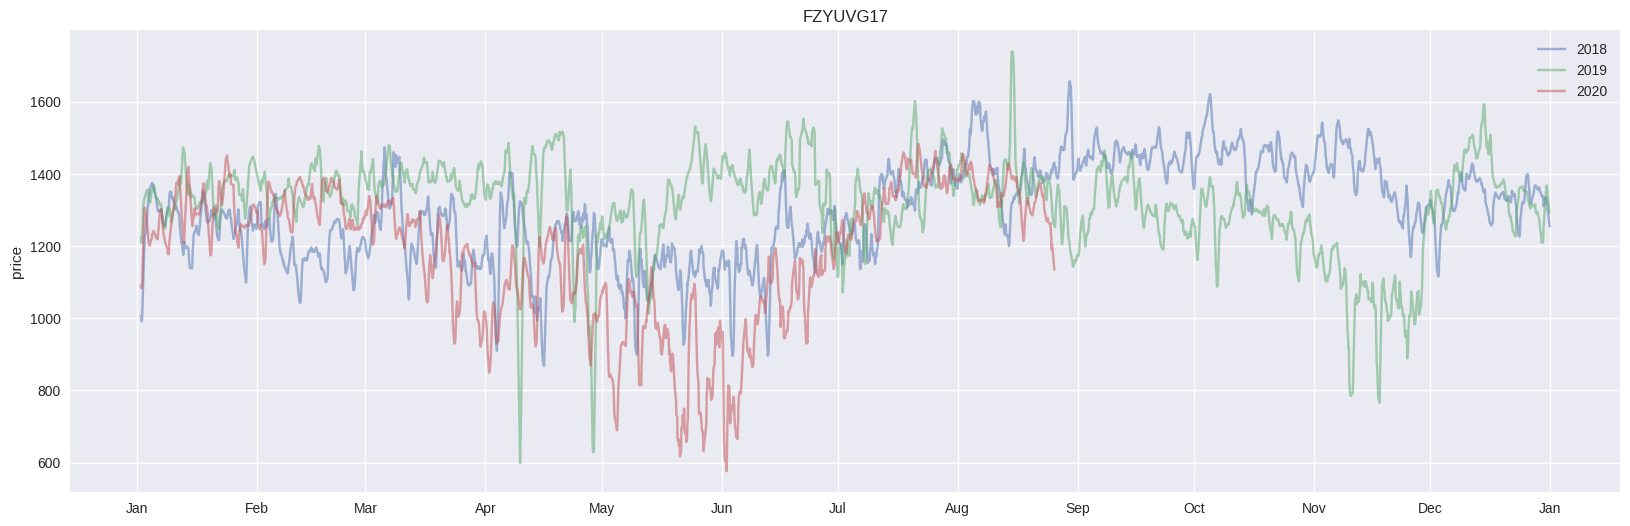

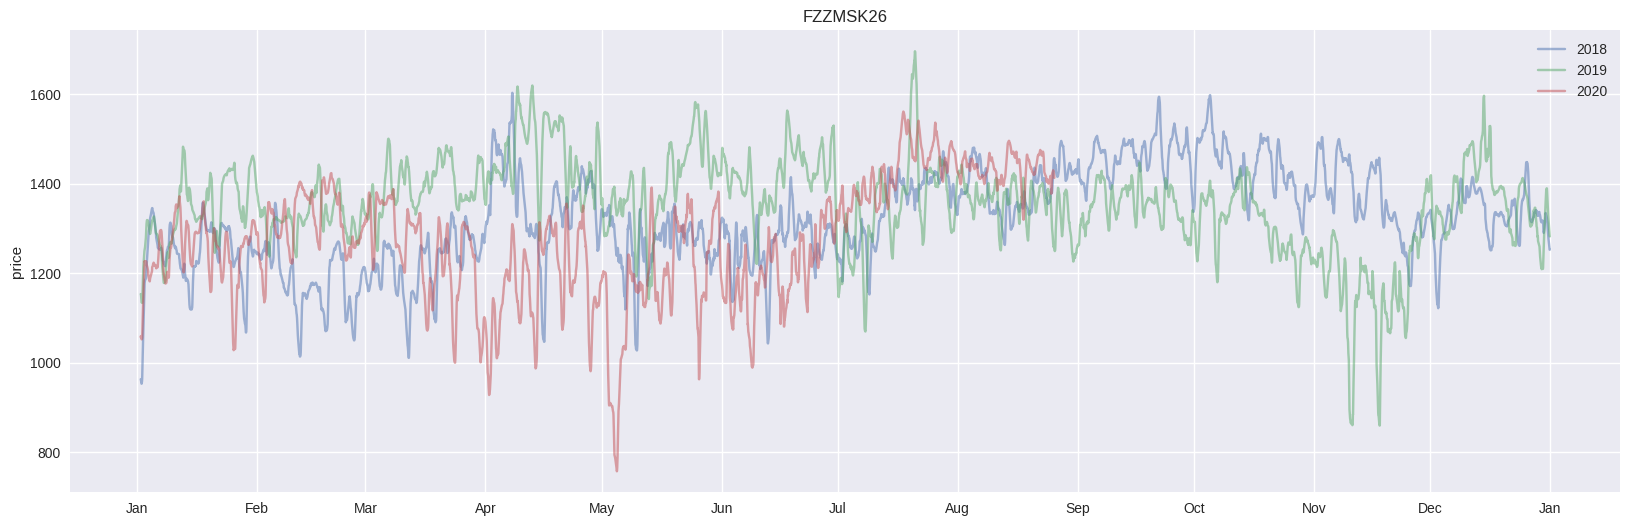

In [69]:
for i in range(10):
    fig,ax=plt.subplots(figsize=(20,6))
    
    # index is the same, since we plot year-long periods
    ix = df.loc[str(2018), ('price',zones[i])].index
    for year in df.index.year.unique():
        vals = ( df.loc[str(year), ('price',zones[i])]
                .rolling(24)
                .mean()
                .values )
        ax.plot(ix[:vals.shape[0]], vals, label=year, alpha=0.5)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=list(range(1,13))))
    ax.set_title(zones[i])
    ax.legend()
    ax.grid()
    ax.set_ylabel('price')

Some series have clear lows during summer, when demand is supposedly low. Others don't.  
2019 shows distinct behavior across most zones.
  
Let's zoom in

### Closer Look
[[To the top]](#Contents)

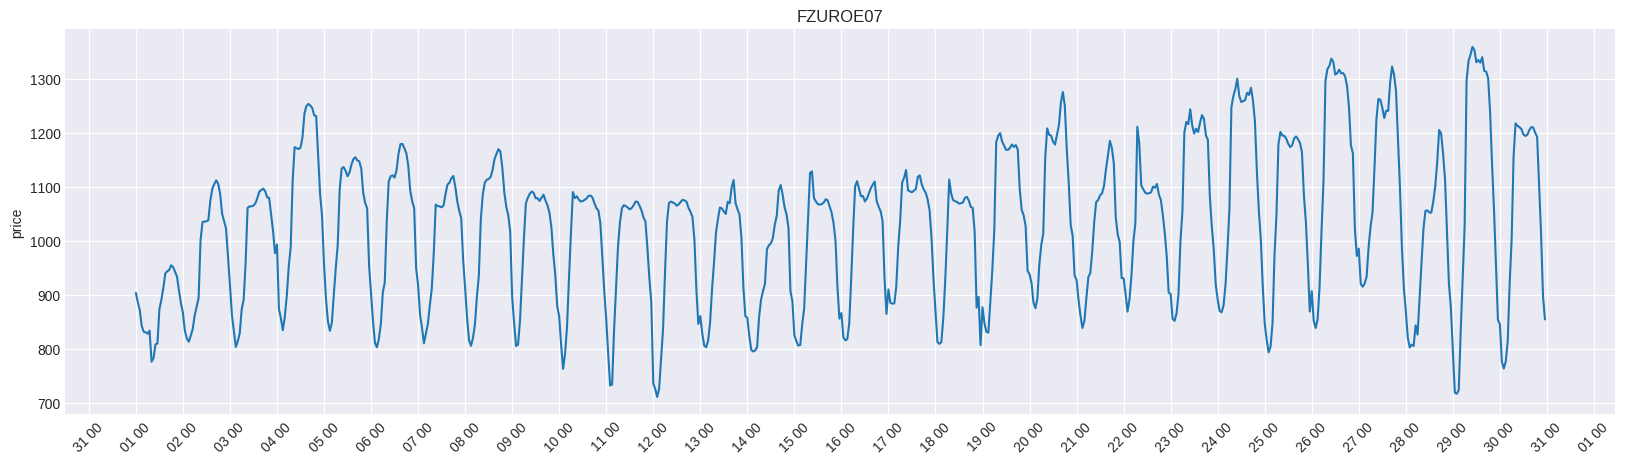

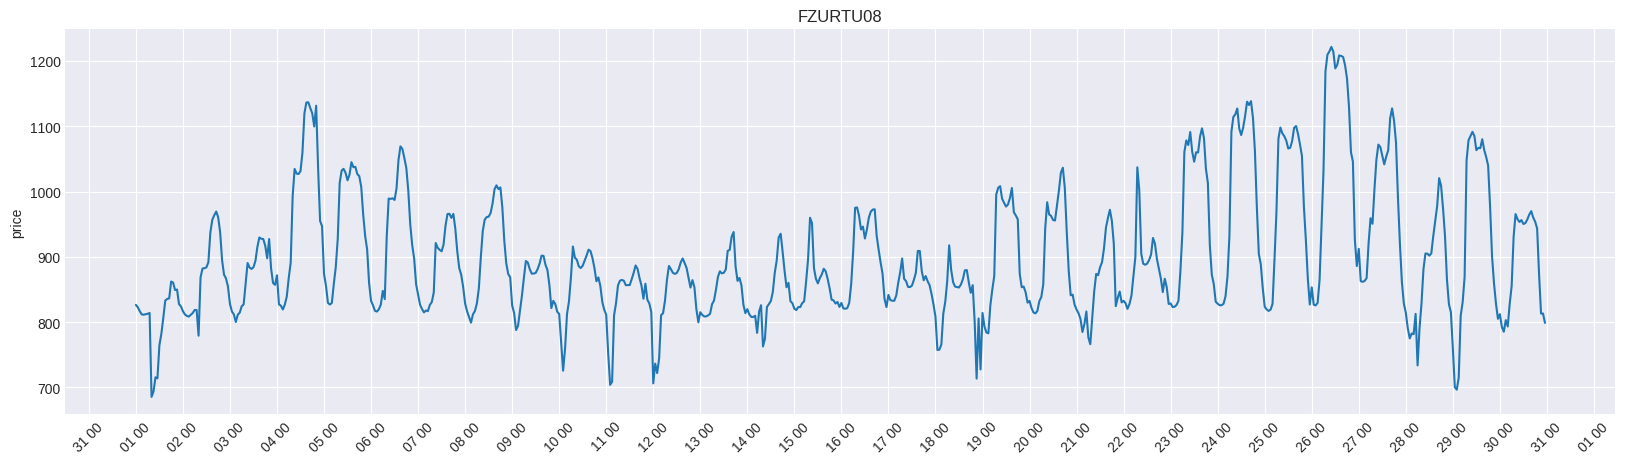

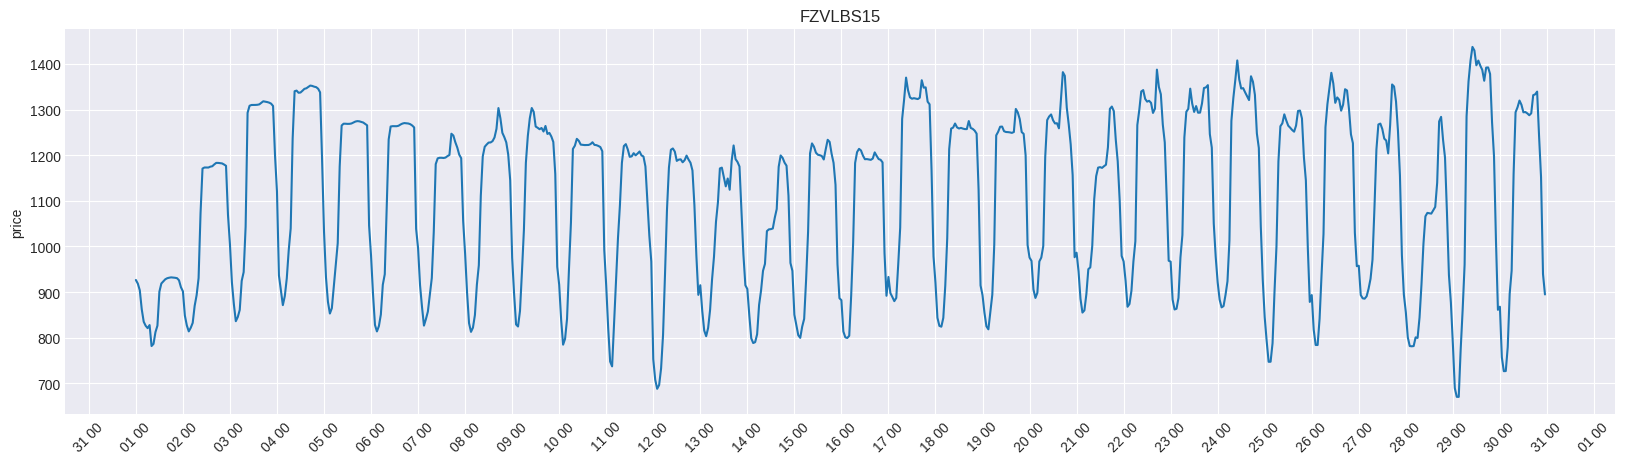

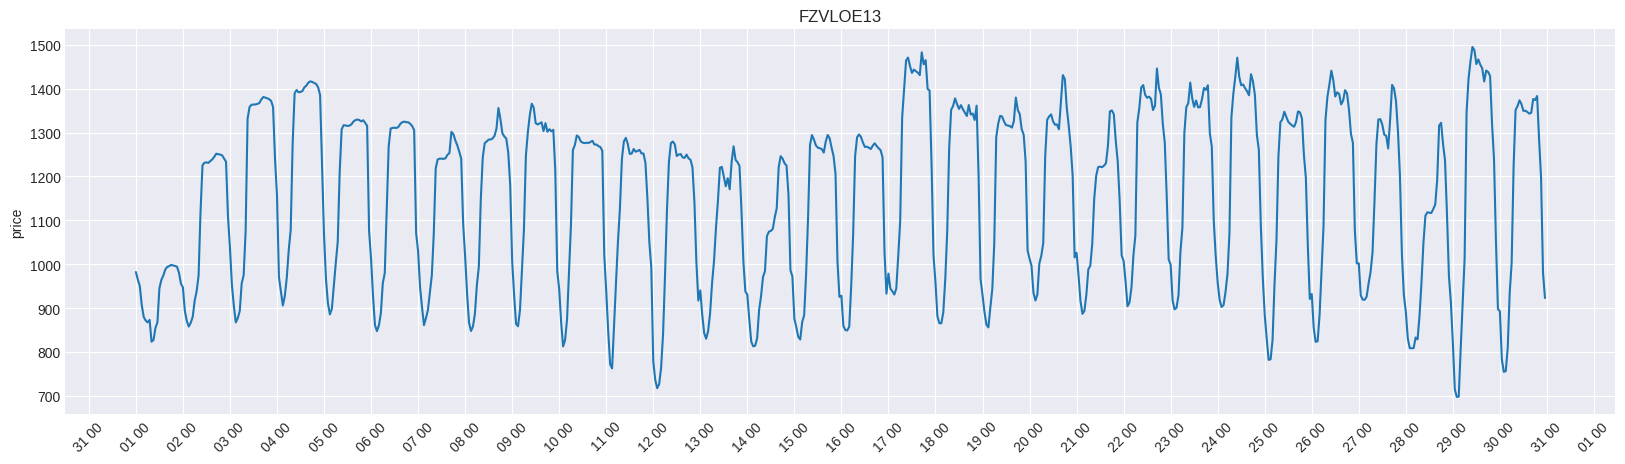

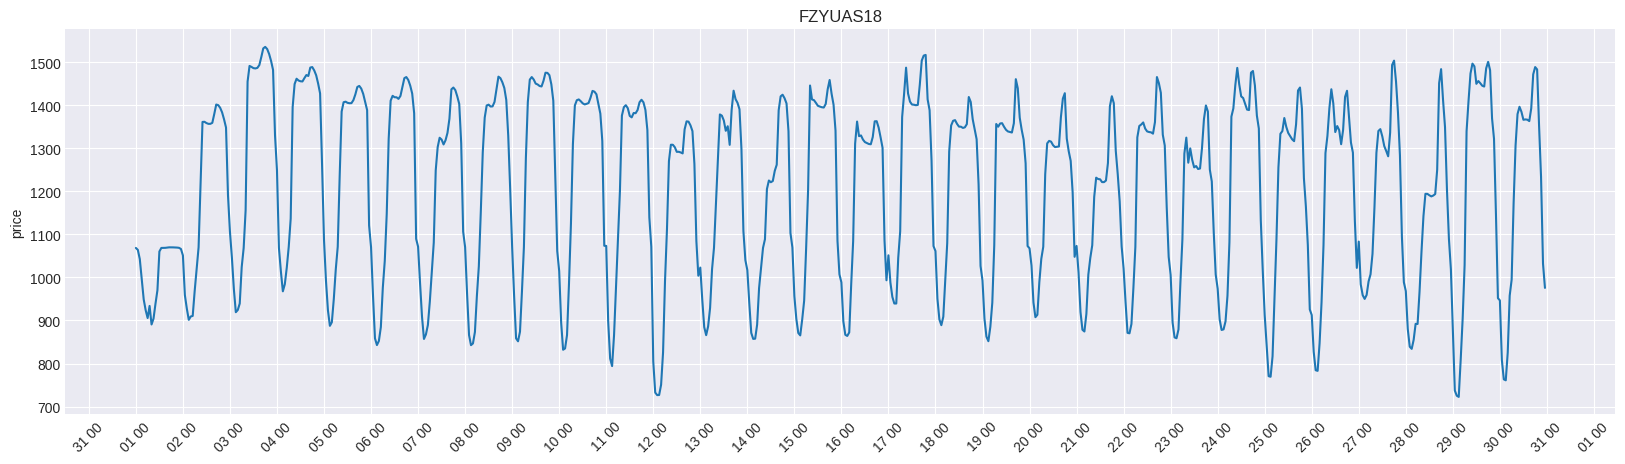

In [69]:
for i in range(5):
    vals = ( df.loc[:, ('price',zones[i])])
    span = 24*30

    fig,ax=plt.subplots(figsize=(20,5))
    ax.plot(vals.iloc[:span].index, vals.iloc[:span])
    
    ax.set_title(zones[i])
    ax.grid()
    ax.set_ylabel('price')
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H'))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0]))

Daily seasonality is clearly seen. Are there more seasonalities?

### Seasonalities
[[To the top]](#Contents)

### Periodogram View

In [101]:
from scipy.signal import periodogram

FZUROE07 ['5802.00', '11604.00', '23208.00', '12.00', '24.00']
FZURTU08 ['2578.67', '11604.00', '12.00', '23208.00', '24.00']
FZVLBS15 ['3868.00', '23208.00', '5802.00', '12.00', '24.00']


FZVLOE13 ['3868.00', '5802.00', '23208.00', '12.00', '24.00']
FZYUAS18 ['4641.60', '5802.00', '23208.00', '12.00', '24.00']
FZYUDA23 ['4641.60', '5802.00', '12.00', '7736.00', '24.00']
FZYUKU20 ['23208.00', '4641.60', '5802.00', '12.00', '24.00']
FZYUOE16 ['23208.00', '5802.00', '7736.00', '12.00', '24.00']
FZYUVG17 ['4641.60', '5802.00', '23208.00', '12.00', '24.00']
FZZMSK26 ['5802.00', '3868.00', '23208.00', '12.00', '24.00']
FZSZKO28 ['3868.00', '11604.00', '12.00', '23208.00', '24.00']
FZSZOE27 ['5802.00', '3868.00', '23208.00', '12.00', '24.00']
FZURKR12 ['7736.00', '5802.00', '23208.00', '12.00', '24.00']
FZZNOE24 ['3868.00', '5802.00', '23208.00', '12.00', '24.00']
FZURNT09 ['7736.00', '5802.00', '12.00', '23208.00', '24.00']


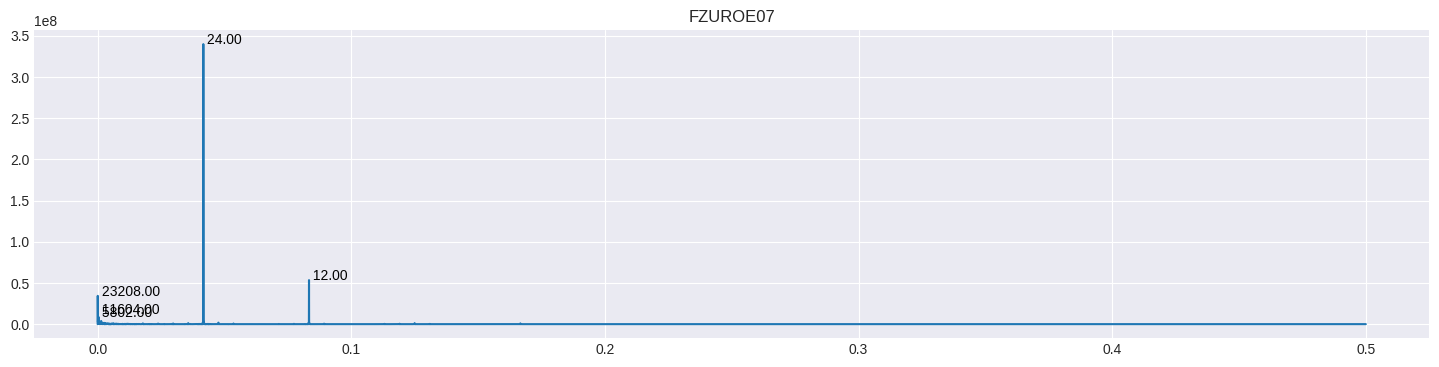

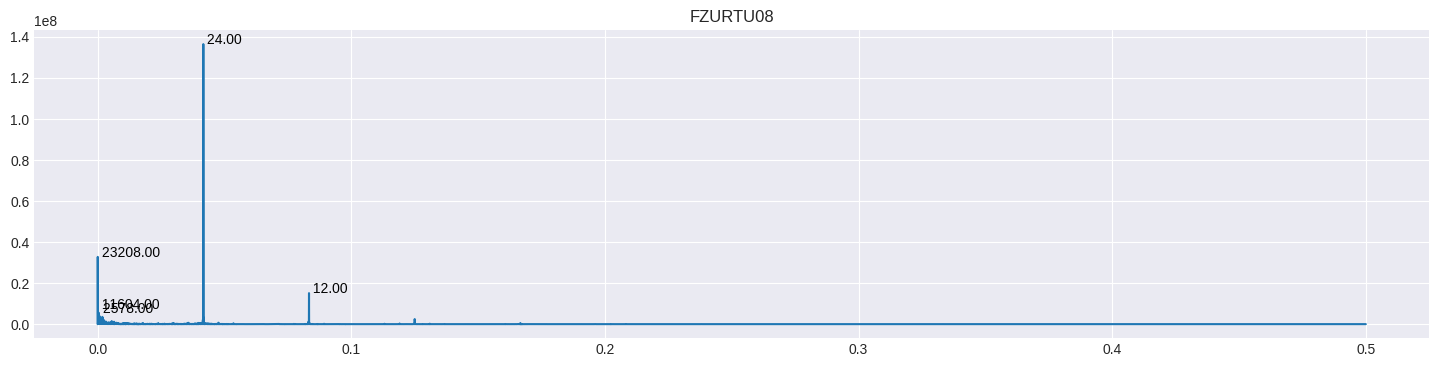

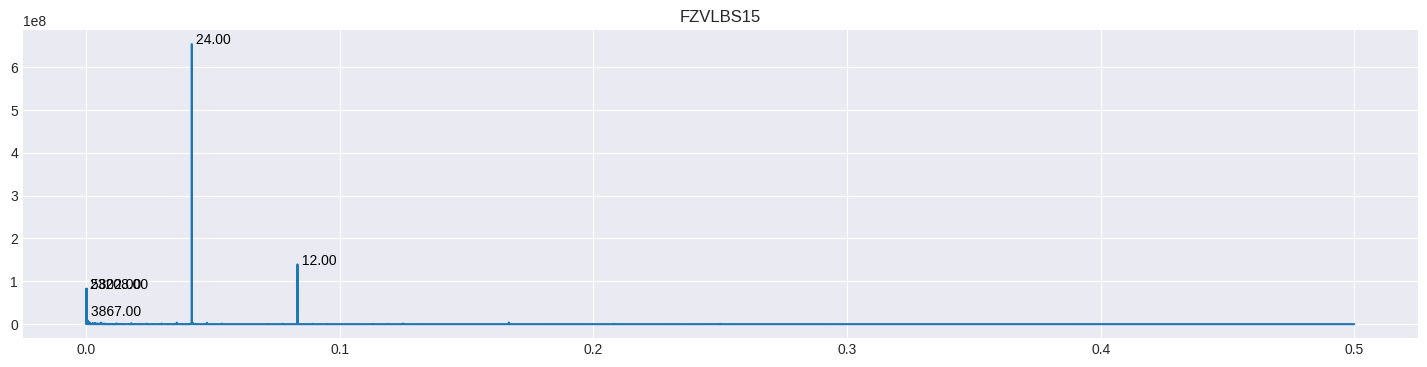

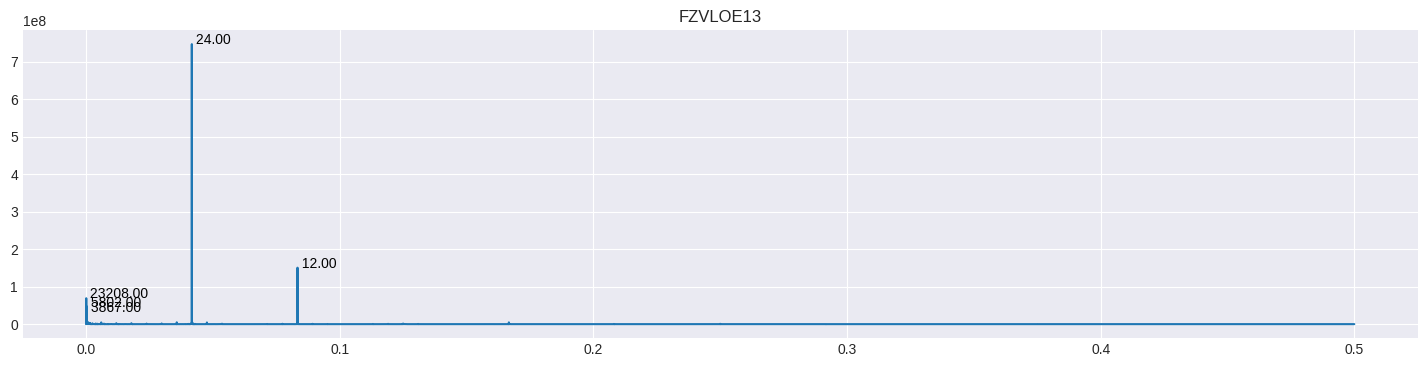

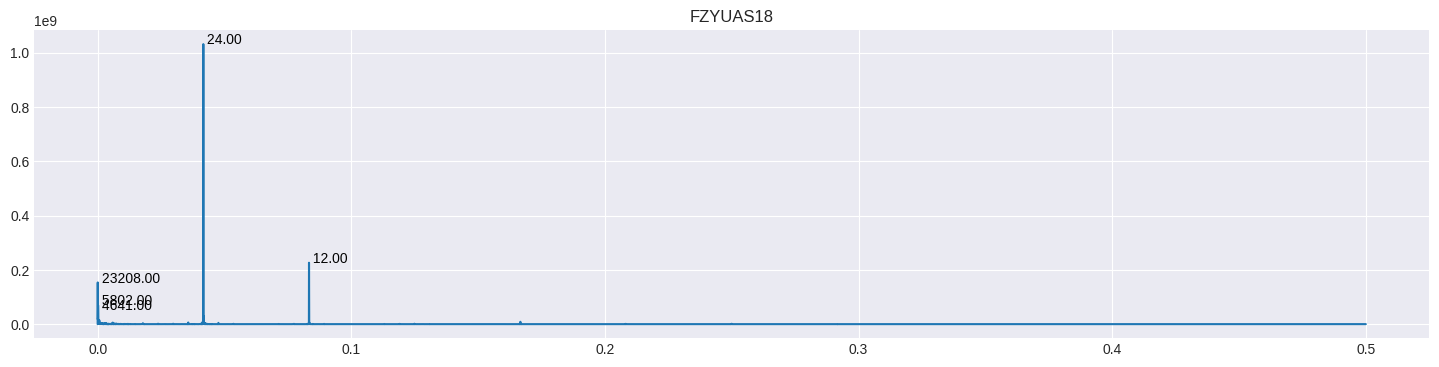

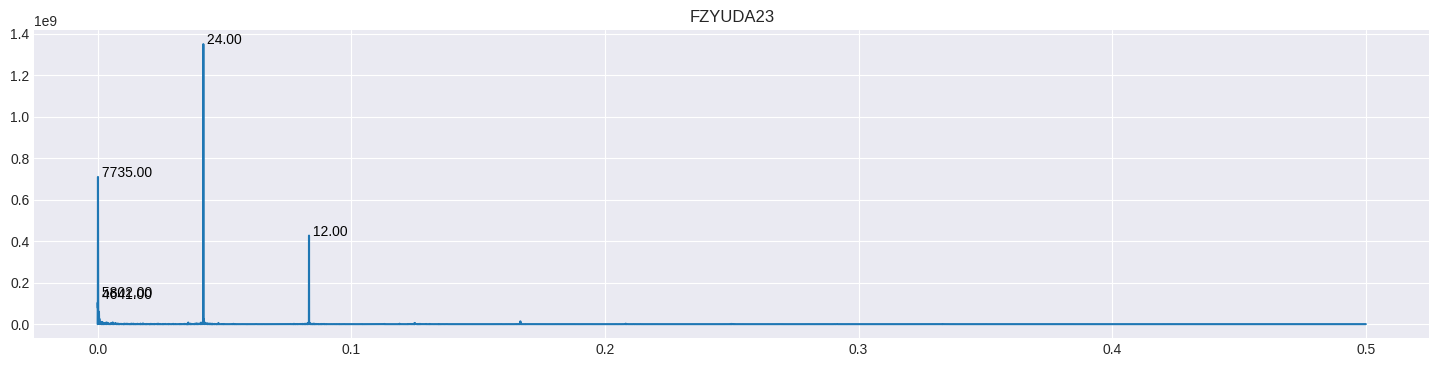

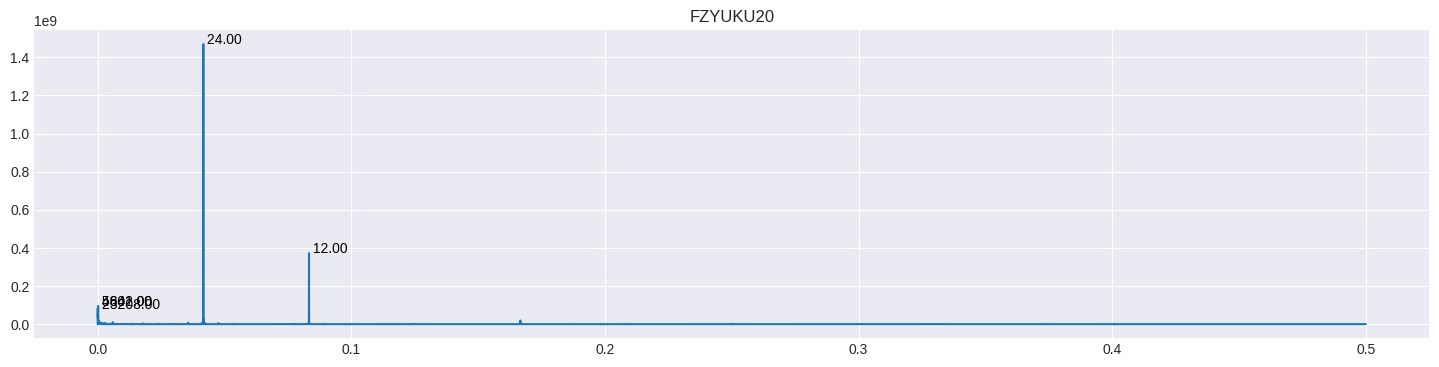

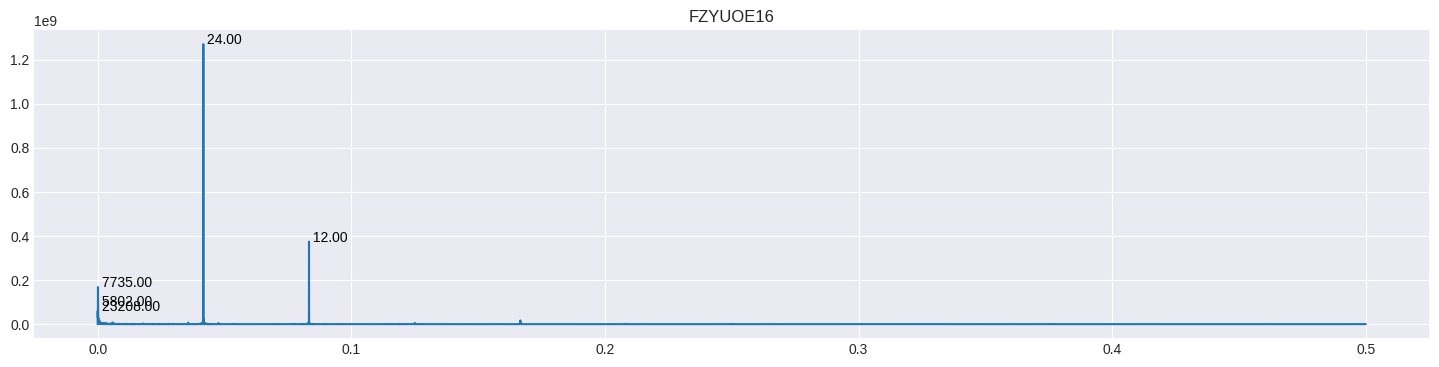

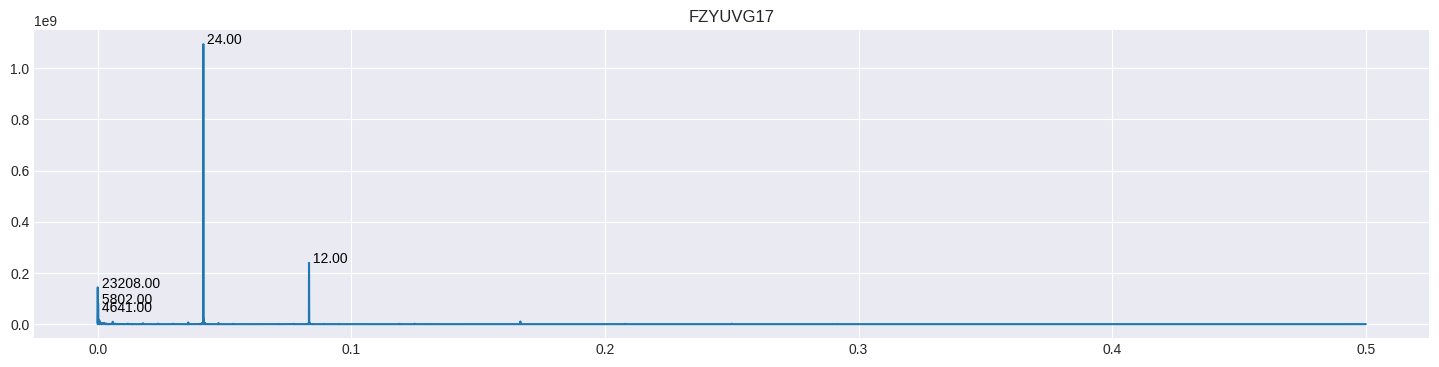

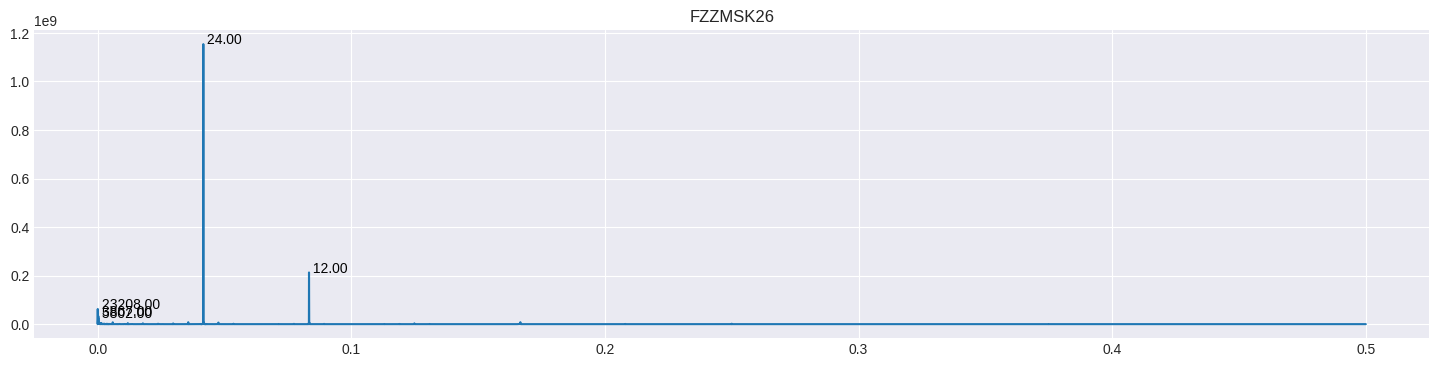

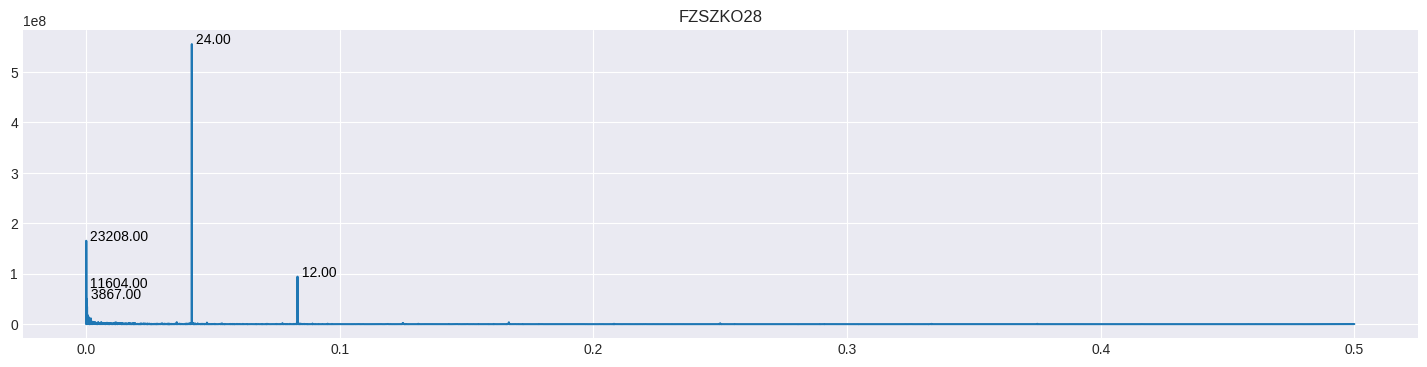

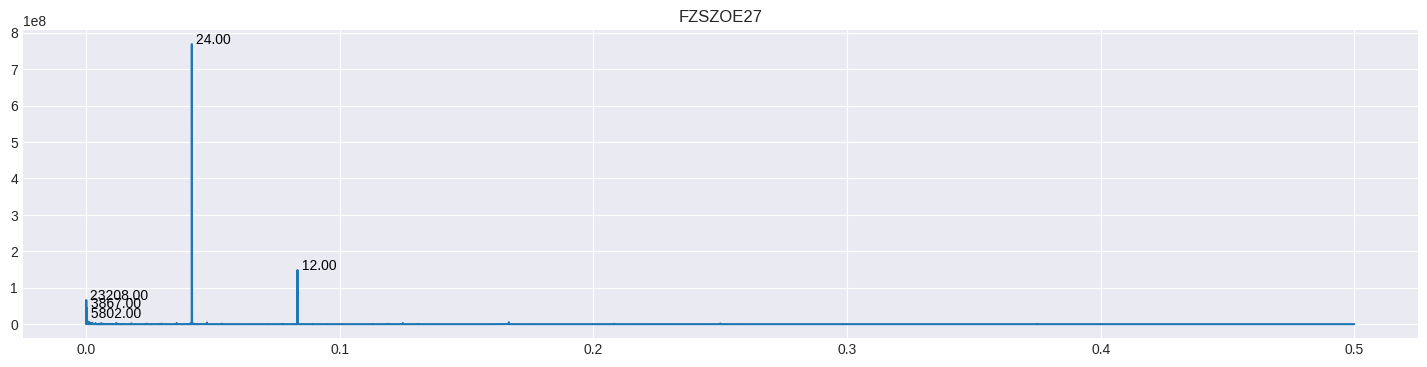

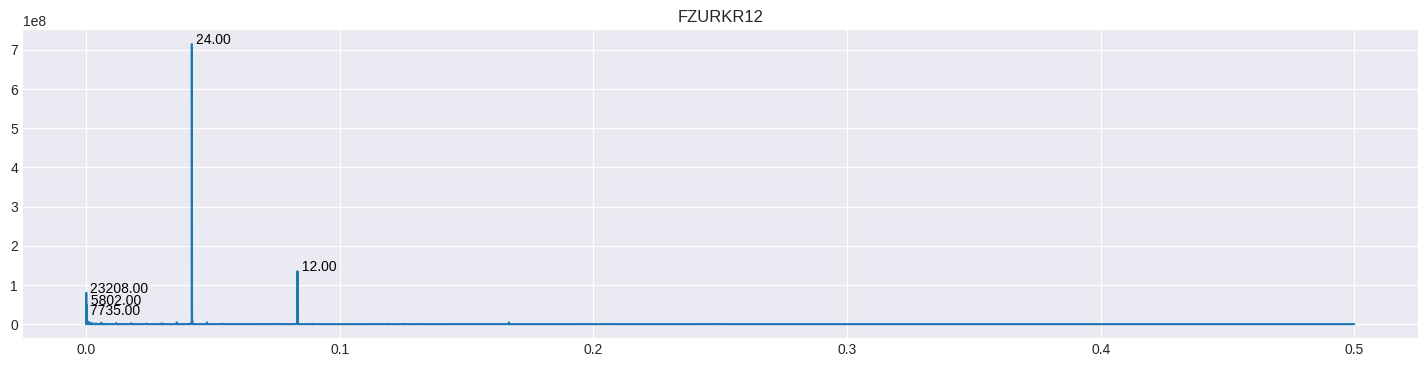

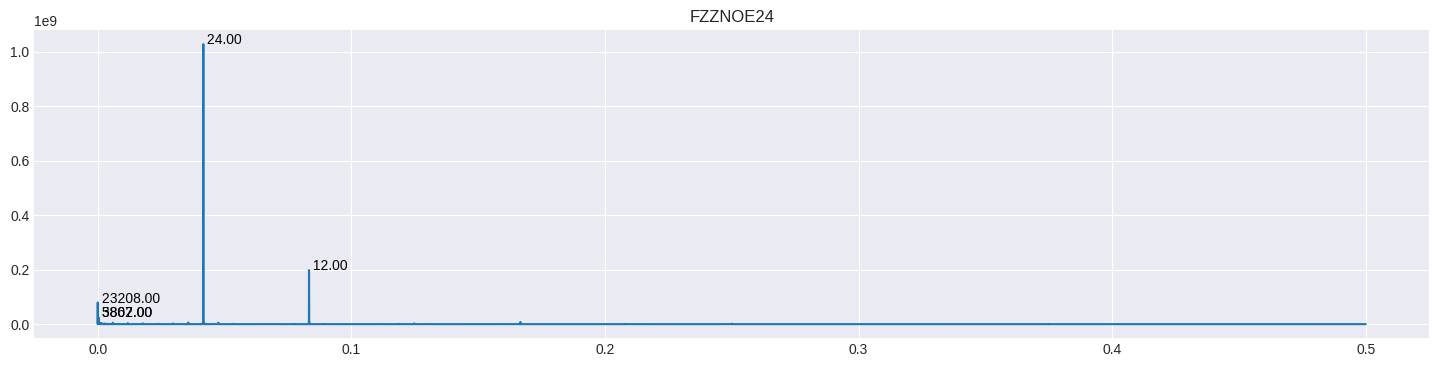

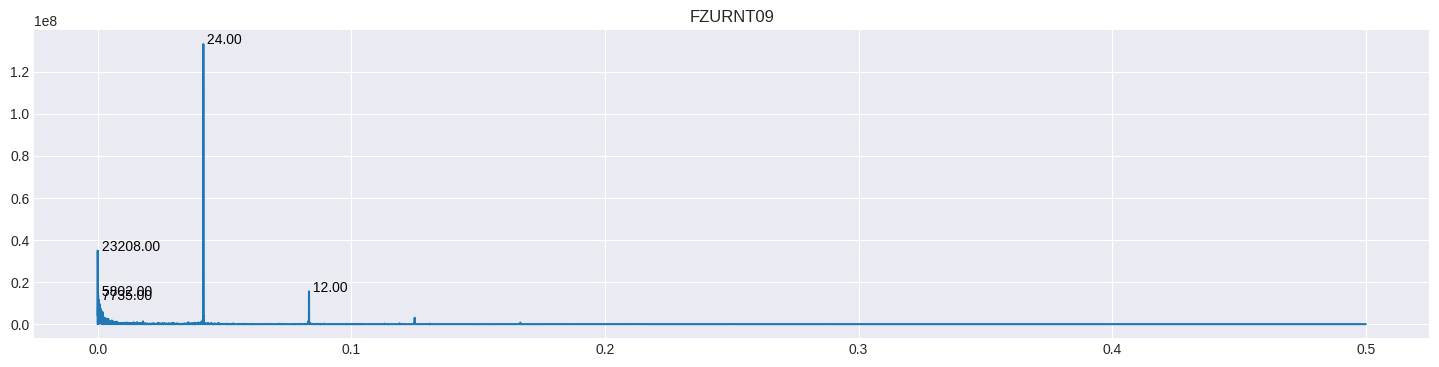

In [113]:
for i in range(len(zones)):
    vals = df.loc[:, ('price',zones[i])].values
    vals-=vals.mean()
    f,p = periodogram(vals, )
    span = 24*30

    fig,ax=plt.subplots(figsize=(18,4))
    inds = np.argsort(p)
    print(zones[i], [f'{1/f[ix]:.2f}' for ix in inds[-5:]])
    ax.plot(f, p)
    for ix in inds[-5:]:
        ax.text(f[ix], p[ix], f'{int(1/f[ix]): .2f}', color='k')

    ax.set_title(zones[i])
    ax.grid()

Periodogram confirms presence of daily seasonality and indicates weaker 12-hour cycle. Among top-5 we also have 5802-, 11604- (2x5802), 3868- and 4641-hour cycles, which amount to 8, 16, 5.4 and 6.5 months respectively  

### ACF View
[[To the top]](#Contents)

In [30]:
import statsmodels.api as sm

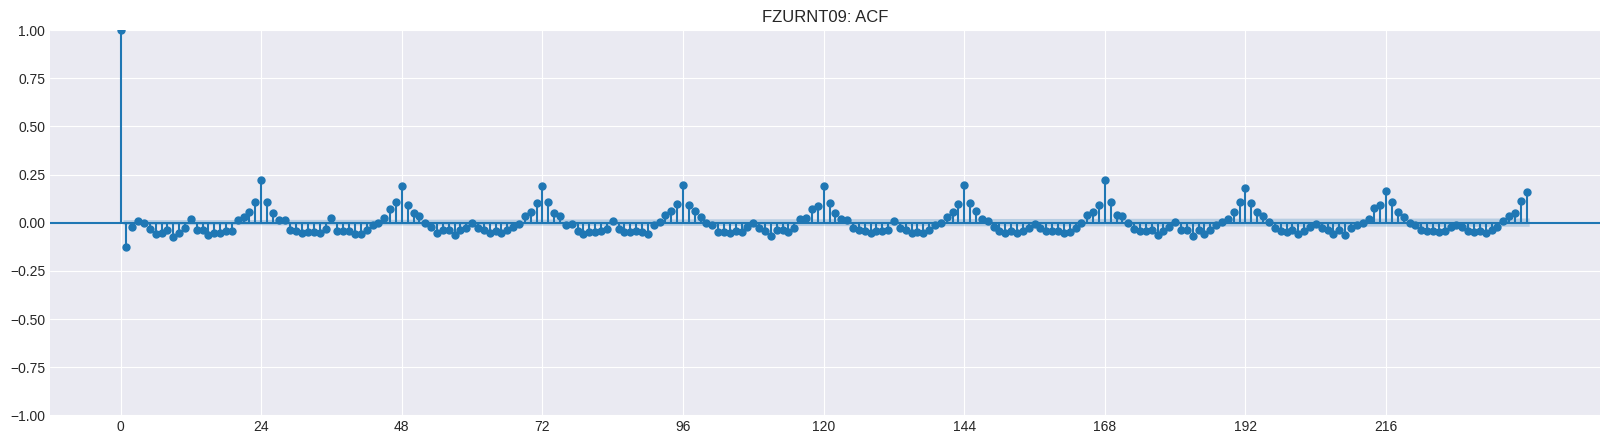

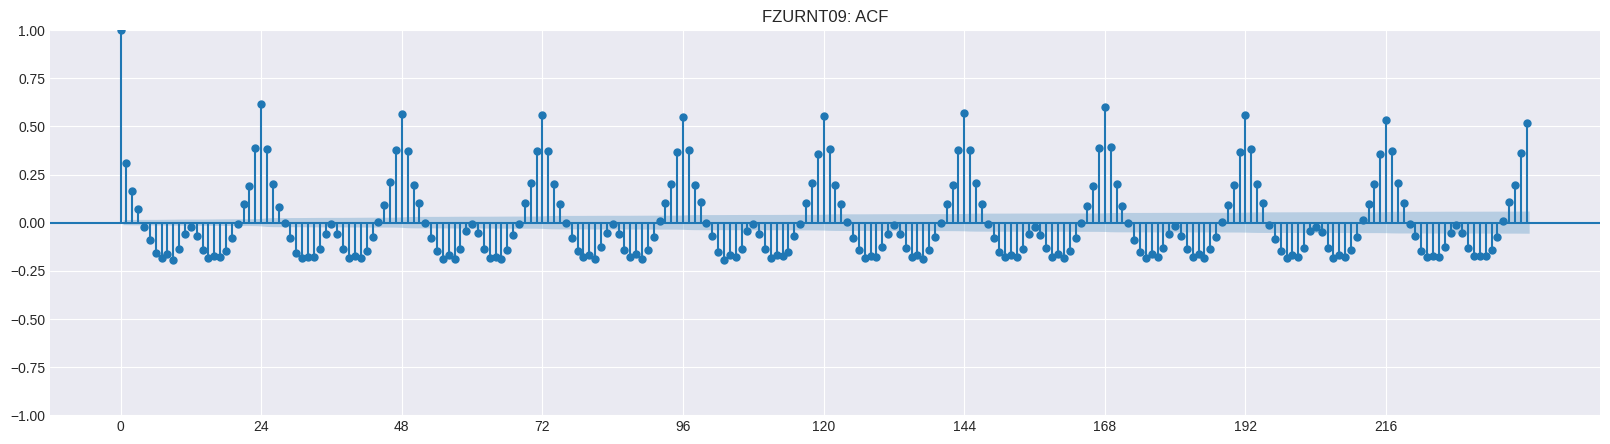

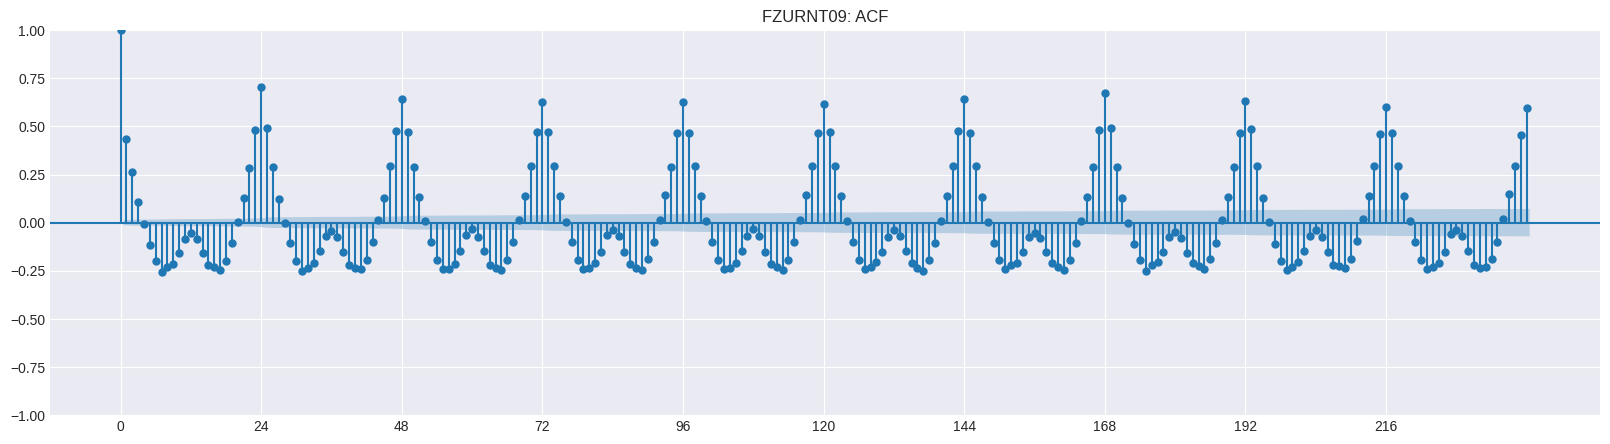

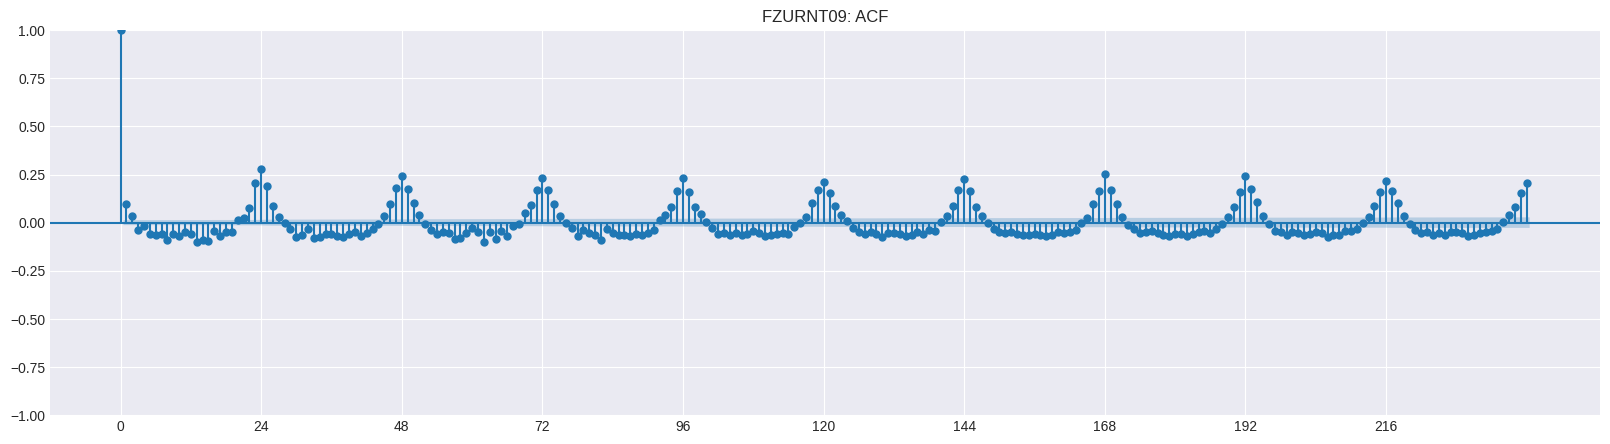

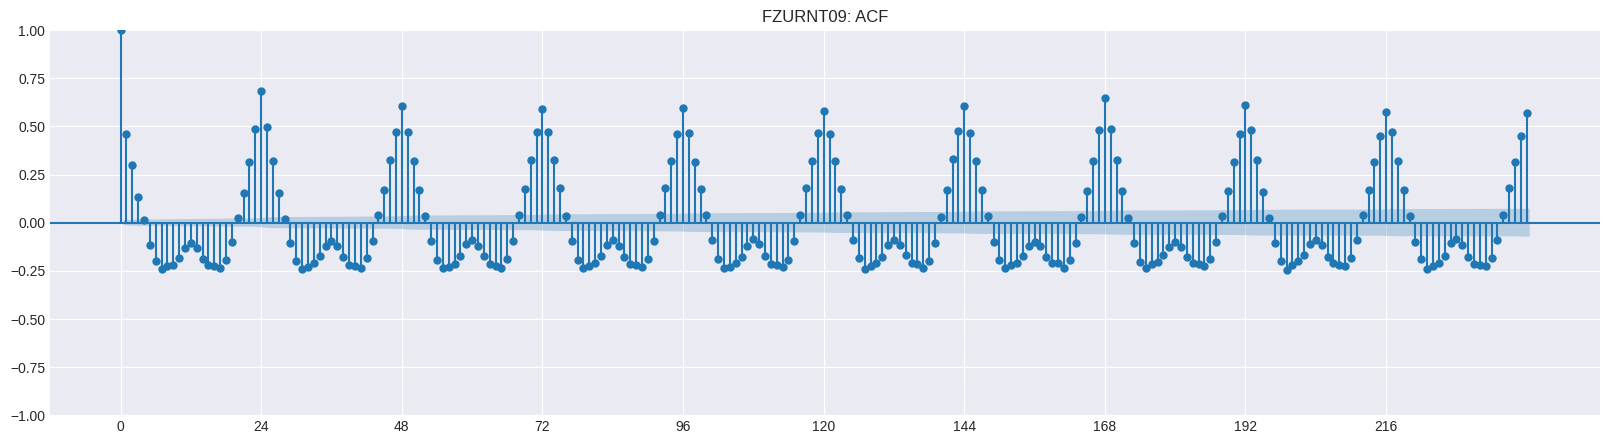

In [32]:
zones = df.columns.get_level_values(1).unique()
for i in range(5):
    
    # differencing
    vals = df.loc[:, ('price',zones[i])].diff(1)
    nlags=24*10

    fig,ax=plt.subplots(figsize=(20,5))
    sm.graphics.tsa.plot_acf(vals.values[1:-1], lags=nlags, ax=ax)
    
    ax.set_xticks(np.arange(0,nlags,24))
    ax.set_title(f'{zone}: ACF')

In [34]:
# ugly way of argmax-ing acf lags for each feature, but it works
( df
 .loc[:,('price',)]
 .diff(1)
    
# drop nan rows, left from differencing (sm.acf can't handle nans) 
.dropna()
.apply(sm.tsa.stattools.acf, adjusted=True, nlags=24*35)

# argmax 
.apply(lambda col: sorted(
    zip(np.arange(df.shape[0]),col),
    key=lambda x:-x[1]))

# rounding acf values 
.map(np.round, decimals=2)
# top 10
.head(10)
)

free_transfer_zone       FZSZKO28       FZSZOE27       FZURKR12  \
0                      [0.0, 1.0]     [0.0, 1.0]     [0.0, 1.0]   
1                    [24.0, 0.22]   [24.0, 0.62]   [24.0, 0.71]   
2                   [168.0, 0.22]  [168.0, 0.61]  [168.0, 0.68]   
3                   [144.0, 0.19]  [144.0, 0.57]  [336.0, 0.65]   
4                    [96.0, 0.19]   [48.0, 0.57]  [144.0, 0.65]   
5                    [72.0, 0.19]  [336.0, 0.57]   [48.0, 0.64]   
6                    [48.0, 0.19]  [192.0, 0.56]  [192.0, 0.64]   
7                   [120.0, 0.19]   [72.0, 0.56]   [96.0, 0.63]   
8                   [192.0, 0.18]  [120.0, 0.56]   [72.0, 0.63]   
9                   [336.0, 0.18]   [96.0, 0.55]  [504.0, 0.63]   

free_transfer_zone       FZURNT09       FZUROE07       FZURTU08  \
0                      [0.0, 1.0]     [0.0, 1.0]     [0.0, 1.0]   
1                    [24.0, 0.28]   [24.0, 0.69]   [24.0, 0.51]   
2                   [168.0, 0.26]  [168.0, 0.65]  [168.0, 0.44]   
3                   [336.0, 0.24]  [336.0, 0.64]  [336.0, 0.42]   
4                    [48.0, 0.24]  [192.0, 0.62]   [48.0, 0.41]   
5                   [192.0, 0.24]  [144.0, 0.61]   [192.0, 0.4]   
6                    [96.0, 0.23]  [504.0, 0.61]    [96.0, 0.4]   
7                    [72.0, 0.23]   [48.0, 0.61]   [144.0, 0.4]   
8                   [144.0, 0.23]   [312.0, 0.6]   [72.0, 0.39]   
9                   [312.0, 0.22]    [96.0, 0.6]  [504.0, 0.39]   

free_transfer_zone       FZVLBS15       FZVLOE13       FZYUAS18  \
0                      [0.0, 1.0]     [0.0, 1.0]     [0.0, 1.0]   
1                    [24.0, 0.64]   [24.0, 0.75]   [24.0, 0.63]   
2                   [168.0, 0.62]  [168.0, 0.73]  [168.0, 0.61]   
3                    [48.0, 0.59]   [336.0, 0.7]   [48.0, 0.61]   
4                   [336.0, 0.59]  [192.0, 0.69]  [192.0, 0.59]   
5                    [72.0, 0.58]  [144.0, 0.69]  [144.0, 0.59]   
6                   [144.0, 0.58]   [48.0, 0.69]   [72.0, 0.59]   
7                   [192.0, 0.58]   [72.0, 0.68]   [96.0, 0.59]   
8                    [96.0, 0.57]   [96.0, 0.67]  [336.0, 0.57]   
9                   [504.0, 0.57]  [504.0, 0.67]  [120.0, 0.57]   

free_transfer_zone       FZYUDA23       FZYUKU20       FZYUOE16  \
0                      [0.0, 1.0]     [0.0, 1.0]     [0.0, 1.0]   
1                    [24.0, 0.46]   [24.0, 0.63]   [24.0, 0.49]   
2                    [48.0, 0.37]  [168.0, 0.59]   [48.0, 0.46]   
3                    [72.0, 0.34]   [48.0, 0.59]   [72.0, 0.43]   
4                   [144.0, 0.32]  [144.0, 0.59]  [144.0, 0.43]   
5                   [168.0, 0.31]  [192.0, 0.58]  [168.0, 0.41]   
6                    [96.0, 0.31]   [72.0, 0.57]   [192.0, 0.4]   
7                    [192.0, 0.3]  [120.0, 0.57]    [96.0, 0.4]   
8                    [216.0, 0.3]   [96.0, 0.57]   [216.0, 0.4]   
9                    [120.0, 0.3]  [336.0, 0.57]   [120.0, 0.4]   

free_transfer_zone       FZYUVG17       FZZMSK26       FZZNOE24  
0                      [0.0, 1.0]     [0.0, 1.0]     [0.0, 1.0]  
1                    [24.0, 0.68]   [24.0, 0.76]   [24.0, 0.76]  
2                   [168.0, 0.65]  [168.0, 0.75]  [168.0, 0.75]  
3                    [48.0, 0.64]  [336.0, 0.71]  [336.0, 0.72]  
4                   [144.0, 0.63]  [144.0, 0.71]  [144.0, 0.71]  
5                   [192.0, 0.63]   [48.0, 0.71]  [192.0, 0.71]  
6                    [72.0, 0.62]  [192.0, 0.71]   [48.0, 0.71]  
7                   [336.0, 0.62]    [96.0, 0.7]    [96.0, 0.7]  
8                    [96.0, 0.61]    [72.0, 0.7]    [72.0, 0.7]  
9                   [120.0, 0.61]   [120.0, 0.7]  [504.0, 0.69]

### Feature Variance
[[To the top]](#Contents)

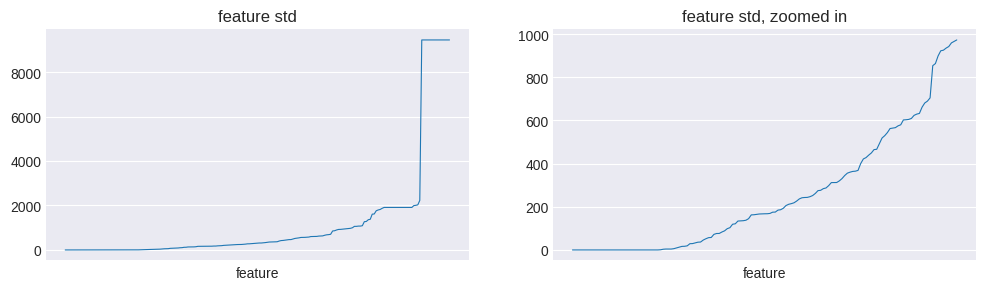

In [49]:
fig,ax=plt.subplots(1,2,figsize=(12,3))
( df
 .select_dtypes('float')
 .std()
 .sort_values()
).plot(xticks=[], title='feature std', lw=0.8, ax=ax[0])
ax[0].set_xlabel('feature')

( df
 .select_dtypes('float')
 .std()
 .sort_values()
 .iloc[:-50]
).plot(xticks=[], title='feature std, zoomed in', lw=0.8, ax=ax[1])
ax[1].set_xlabel('feature');

In [50]:
# dropping low variance features
var_threshold = 1e-5
df = ( df
 .drop(columns = df.columns[df.std(axis=0)<var_threshold])
)
df.shape

(23208, 162)

### Complete Preprocessing 
[[To the top]](#Contents)

In [47]:
def process(path: str) -> pd.DataFrame:
    """Preprocessing of the energy dataset
    """
    new_names = ['date', 
             'price_zone', 
             'free_transfer_zone', 
             'hour', 
             'hydro_plan',
             'nuclear_plan', 
             'thermal_plan', 
             'thermal_min', 
             'thermal_max',
             'consumption', 
             'export',
             'import',
             'solar_plan',
             'wind_plan',
             'renewable_plan',
             'supply_1',
             'supply_2',
             'price',
            ]
    
    # haven't figured out how to rename *multilevel* columns in a functional way
    def rename(df):
        df.columns = [f'{col[1]}_{col[0]}' for col in df.columns]
        return df
    
    # zero variance threshold
    variance_eps = 1e-6
    
    df = ( pd
      .read_csv(path)
      
       # rename columns for better access/readability
      .pipe(lambda df: df.rename(columns = dict(zip(df.columns, new_names))))
       
       # casting/shrinking
      .astype({'date': 'datetime64[ns]',
               'free_transfer_zone': 'category',
               'hour': 'int8'})
      .pipe(lambda df: df.astype({ col: 'float32' 
                                  for col in df.select_dtypes('float64').columns }))
      
      # drop zero-variance features
      .drop(columns = ['price_zone',
                       'renewable_plan'])
      
      # removing trailing spaces
      .pipe(lambda df: df.assign(free_transfer_zone =
              df.free_transfer_zone.cat.rename_categories(lambda s: s.strip())))
      
      # combining hours and dates into a single feature
      .pipe(lambda df: df.assign( dtime = df['date'] + pd.to_timedelta(df.hour, unit='hour')))
      
      .drop(columns = ['date', 'hour'])
            
      .pivot(index='dtime', columns='free_transfer_zone')
      .sort_index()
            
      .pipe(lambda df: df.drop(columns = df.columns[df.std(axis=0)<variance_eps]))
        
      .pipe(rename)
      #.pipe(lambda df: df.columns = [f'{col[1]}_{col[0]}' for col in df.columns])  
    )
    return df